# Implementing transfer learning on Vgg16 using pyTorch

Hi! I am  [Jean-Nicolas Jérémie](https://laurentperrinet.github.io/author/jean-nicolas-jeremie/) and the goal of this notebook is to provide a framework to implement (and experiment with) [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) on deep convolutional neuronal network (DCNN). In a nutshell, [transfer learning](https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/) allows to re-use the knowlegde learned on a problem, such as categorizing images from  a large dataset, and apply it to a different (yet related) problem, performing the categorization on a smaller dataset. It is a powerful method as it allows to implement complex task *de novo* quite rapidly (in a few hours) without having to retrain the millions of parameters of a DCNN (which takes days of computations). The basic hypothesis is that it suffices to [re-train the last classification layers](https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch) (the head) while keeping the first layers fixed. Here, these networks teach us also some interesting insights into how living systems may perform such categorization tasks.

Based on our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html), we will start from a [VGG16 network](https://pytorch.org/hub/pytorch_vision_vgg/) loaded from the [`torchvision.models` library](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py) and pre-trained on the [Imagenet](http://image-net.org/) dataset wich allows to perform label detection on naturals images for $K = 1000$ labels. Our goal here will be to re-train the last fully-Connected layer of the network to perfom the same task but in a sub-set of $K = 10$ labels from the Imagenet dataset. 

Moreover, we are going to evaluate different strategies of transfer learning:

* VGG General : Substitute the last layer of the pyTorch VGG16 network ($K = 1000$ labels) with a new layer build from a specific subset ($K = 10$ labels).
* VGG Linear : Add a new layer build from a specific subset ($K = 10$ labels) after the last Fully-Connected layer of the the pyTorch VGG16 network.
* VGG Gray : Same architecture as the VGG General network but trained with grayscale images.
* VGG Scale : Same architecture as the VGG General network but trained with images of different size.

In this notebook, I will use the [pyTorch](https://pytorch.org/) library for running the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This notebook was done during a master 2 internship at the Neurosciences Institute of Timone (INT) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/). It is curated in the following [github repo](https://github.com/JNJER/2020-06-26_fast_and_curious.git).

<!-- TEASER_END -->

In our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html), as the VGG16 network was first trained on the entire dataset of $K=1000$ labels, and in order to recover the classification confidence predicted by the model according to the specific subset of classes ($K = 10$ labels) on which it is tested, the output `softmax` mathematical function of the last layer of the network was slightly changed. By assuming that we know *a priori* that the image belongs to one (and only one) category from the sub-set the probabilities obtained would correspond to a confidence of classification discriminating only the classes of interest and can be compared to a chance level of $1 /K$. This creates another network (which is not retrained) directly based on VGG:

* VGG Subset : Just consider the specific subset ($K = 10$ labels) from the last layer of the pyTorch VGG16 network ($K = 1000$ labels).

This notebook aims in addition to test this hypothesis. Our use case consists of measuring whether there are differences in the likelihood of these networks during an image recognition task on a sub-set of $1000$ classes of the `ImageNet` library, with $K = 10$ (experiment 1). Additionally, we will implement some image transformations as up/down-sampling (experiment 2) or transforming to grayscale (experiment 3) to quantify their influence on the accuracy and computation time of each network.


*Some useful links :*

* https://jaketae.github.io/study/pytorch-vgg/
* https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch
* https://www.kaggle.com/paultimothymooney/detect-retina-damage-from-oct-images/notebook

* https://en.wikipedia.org/wiki/Transfer_learning
* https://github.com/laurentperrinet/ImageNet-Datasets-Downloader/tree/8d1c0925b5512f48978177a76e7b851ff40acb7b

Let's first install requirements

In [1]:
%pip install --upgrade -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
# uncommment to re-run training
#%rm -fr models
%mkdir -p DCNN_training_benchmark
%mkdir -p results
%mkdir -p models

## Initialization of the libraries/variables

Our coding strategy is to build up a small library as a package of scripts in the `DCNN_benchmark` folder and to run all calls to that library from this notebook. This follows our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html) in which we benchmarked various DCNNs and which allowed us to select VGG16 as a good compromise between performance and complexity.

First of all, a `init.py` script defines all our usefull variables like the new labels to learn, the number of training images or the root folder to use. Also, we import libraries to train the different networks and display the results.

In [3]:
scriptname = 'DCNN_training_benchmark/init.py'

In [4]:
%%writefile {scriptname}

# Importing libraries
import argparse
import imageio
import json
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
import numpy as np
#from numpy import random
import os
import requests
import time

from time import strftime, gmtime
datetag = strftime("%Y-%m-%d", gmtime())
datetag = '2021-10-10'

HOST = os.uname()[1]
HOST = 'inv-ope-de06'

#to plot & display 
def pprint(message): #display function
    print('-'*len(message))
    print(message)
    print('-'*len(message))
    
# to store results
import pandas as pd

def arg_parse():
    DEBUG = 25
    DEBUG = 1
    parser = argparse.ArgumentParser(description='DCNN_training_benchmark/init.py set root')
    parser.add_argument("--root", dest = 'root', help = "Directory containing images to perform the training",
                        default = 'data', type = str)
    parser.add_argument("--folders", dest = 'folders', help =  "Set the training, validation and testing folders relative to the root",
                        default = ['test', 'val', 'train'], type = list)
    parser.add_argument("--N_images", dest = 'N_images', help ="Set the number of images per classe in the train folder",
                        default = [400//DEBUG, 200//DEBUG, 800//DEBUG], type = list)
    parser.add_argument("--HOST", dest = 'HOST', help = "Set the name of your machine",
                    default=HOST, type = str)
    parser.add_argument("--datetag", dest = 'datetag', help = "Set the datetag of the result's file",
                    default = datetag, type = str)
    parser.add_argument("--image_size", dest = 'image_size', help = "Set the default image_size of the input",
                    default = 256)
    parser.add_argument("--image_sizes", dest = 'image_sizes', help = "Set the image_sizes of the input for experiment 2 (downscaling)",
                    default = [64, 128, 256, 512], type = list)
    parser.add_argument("--num_epochs", dest = 'num_epochs', help = "Set the number of epoch to perform during the traitransportationning phase",
                    default = 50//DEBUG)
    parser.add_argument("--batch_size", dest = 'batch_size', help="Set the batch size", default = 16)
    parser.add_argument("--lr", dest = 'lr', help="Set the learning rate", default = 0.001)
    parser.add_argument("--momentum", dest = 'momentum', help="Set the momentum", default = 0.9)
    parser.add_argument("--i_labels", dest = 'i_labels', help="Set the labels of the classes (list of int)",
                    default = [945, 513, 886, 508, 786, 310, 373, 145, 146, 396], type = list)
    parser.add_argument("--class_loader", dest = 'class_loader', help = "Set the Directory containing imagenet downloaders class",
                        default = 'imagenet_label_to_wordnet_synset.json', type = str)
    parser.add_argument("--url_loader", dest = 'url_loader', help = "Set the file containing imagenet urls",
                        default = 'Imagenet_urls_ILSVRC_2016.json', type = str)
    parser.add_argument("--model_path", dest = 'model_path', help = "Set the path to the pre-trained model",
                        default = 'models/re-trained_', type = str)
    parser.add_argument("--model_names", dest = 'model_names', help = "Modes for the new trained networks",
                        default = ['vgg16_gray', 'vgg16_lin', 'vgg16_gen', 'vgg16_scale',], type = list)
    return parser.parse_args()

args = arg_parse()
datetag = args.datetag
json_fname = os.path.join('results', datetag + '_config_args.json')
load_parse = False # False to custom the config

if load_parse:
    with open(json_fname, 'rt') as f:
        print(f'file {json_fname} exists: LOADING')
        override = json.load(f)
        args.__dict__.update(override)
else:
    print(f'Creating file {json_fname}')
    with open(json_fname, 'wt') as f:
        json.dump(vars(args), f, indent=4)
    
# matplotlib parameters
colors = ['b', 'r', 'k', 'g', 'm']
fig_width = 20
phi = (np.sqrt(5)+1)/2 # golden ratio for the figures :-)

#DCCN training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Select a device (CPU or CUDA)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('On date', datetag, ', Running benchmark on host', args.HOST, ' with device', device.type)

# Datasets Configuration
image_size = args.image_size # default image resolution
image_sizes =  args.image_sizes # resolutions explored in experiment 2
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=mean, std=std) # to normalize colors on the imagenet dataset


N_labels = len(args.i_labels)
id_dl = []
model_filenames = {}

paths = {}
reverse_id_labels = {}
N_images_per_class = {}
labels = []

for folder, N_image in zip(args.folders, args.N_images):
    paths[folder] = os.path.join(args.root, folder) # data path
    N_images_per_class[folder] = N_image
    
with open(args.class_loader, 'r') as fp: # get all the classes on the data_downloader
    imagenet = json.load(fp)

# gathering labels
for a, img_id in enumerate(imagenet):
    reverse_id_labels[str('n' + (imagenet[img_id]['id'].replace('-n','')))] = imagenet[img_id]['label'].split(',')[0]
    labels.append(imagenet[img_id]['label'].split(',')[0])
    if int(img_id) in args.i_labels:
        id_dl.append('n' + (imagenet[img_id]['id'].replace('-n','')))    
        
# a reverse look-up-table giving the index of a given label (within the whole set of imagenet labels)
reverse_labels = {}
for i_label, label in enumerate(labels):
    reverse_labels[label] = i_label
# a reverse look-up-table giving the index of a given i_label (within the sub-set of classes)
reverse_i_labels = {}
for i_label, label in enumerate(args.i_labels):
    reverse_i_labels[label] = i_label
    
# a reverse look-up-table giving the label of a given index in the last layer of the new model (within the sub-set of classes)
reverse_model_labels = []
pprint('List of Pre-selected classes : ')
# choosing the selected classes for recognition
for i_label, id_ in zip(args.i_labels, id_dl) : 
    reverse_model_labels.append(labels[i_label])
    print('-> label', i_label, '=', labels[i_label], '\nid wordnet : ', id_)
reverse_model_labels.sort()

Overwriting DCNN_training_benchmark/init.py


In [5]:
%run -int {scriptname} 

Creating file results/2021-10-10_config_args.json
On date 2021-10-10 , Running benchmark on host inv-ope-de06  with device cuda
-------------------------------
List of Pre-selected classes : 
-------------------------------
-> label 945 = bell pepper 
id wordnet :  n02056570
-> label 513 = cornet 
id wordnet :  n02058221
-> label 886 = vending machine 
id wordnet :  n02219486
-> label 508 = computer keyboard 
id wordnet :  n02487347
-> label 786 = sewing machine 
id wordnet :  n02643566
-> label 310 = ant 
id wordnet :  n03085013
-> label 373 = macaque 
id wordnet :  n03110669
-> label 145 = king penguin 
id wordnet :  n04179913
-> label 146 = albatross 
id wordnet :  n04525305
-> label 396 = lionfish 
id wordnet :  n07720875

IPython CPU timings (estimated):
  User   :       0.62 s.
  System :       0.10 s.
Wall time:       0.83 s.


## Download the `train` & `val` dataset

In the `dataset.py`, we use an archive of the Imagenet fall 2011 urls to populate datasets based on the pre-selected classes listed in the `DCNN_benchmark/init.py` file. The following script is inspired by [previous work](https://github.com/laurentperrinet/ImageNet-Datasets-Downloader/) in our group.

In [6]:
scriptname = 'DCNN_training_benchmark/dataset.py'

In [7]:
%%writefile {scriptname}

from DCNN_training_benchmark.init import *  

from requests.exceptions import ConnectionError, ReadTimeout, TooManyRedirects, MissingSchema, InvalidURL

#IMG_EXT = ('jpg', 'jpeg', 'png', 'ppm', 'bmp', 'pgm', 'tif', 'tiff', 'webp')   
verbose = False 
save = True

#Imagenet_urls_ILSVRC_2016 = []
with open(args.url_loader) as json_file:
    Imagenet_urls_ILSVRC_2016 = json.load(json_file)

def clean_list(list_dir, patterns=['.DS_Store']):
    for pattern in patterns:
        if pattern in list_dir: list_dir.remove('.DS_Store')
    return list_dir
    
def get_image(img_url, class_folder, timeout=3.):
    worked = 0
    to_save = True 
    if verbose:
        print(f'Processing {img_url}')

    if len(img_url) <= 1:
        to_save = False

    try:
        img_resp = requests.get(img_url, timeout=timeout)
    except ConnectionError:
        if verbose :
            print(f"Connection Error for url {img_url}")
        return fail_get_image()

    except ReadTimeout:
        if verbose :
            print(f"Read Timeout for url {img_url}")
        return fail_get_image()
    
    except TooManyRedirects:
        if verbose :
            print(f"Too many redirects {img_url}")
        return fail_get_image()
    
    except MissingSchema:
        if verbose :
            print('MissingSchema failure')
        return fail_get_image()
    
    except InvalidURL:
        if verbose :
            print('InvalidURL failure')
        return fail_get_image()

    if not 'content-type' in img_resp.headers and to_save :
        if verbose :
            print('No content-type')
        to_save = False
    elif not 'image' in img_resp.headers['content-type'] and to_save :
        if verbose :
            print('Not an image')
        to_save = False
        
    if (len(img_resp.content) < 5000) and to_save :
        if verbose :
            print('Content to short')
        to_save = False

    img_name = img_url.split('/')[-1]
    img_name = img_name.split("?")[0]

    if (len(img_name) <= 1) and to_save:
        if verbose :
            print('Bad name for the image')
        to_save = False
    
    if 'jpe' in img_name or 'gif' in img_name :
        if verbose :
            print('Bad format for the image')
        to_save = False
    
    if img_name in os.listdir(class_folder):
        worked = 1
        return worked

    # LuP some files miss the extension?
    if not 'jpg' in img_name :
        img_name += 'jpg'
    
    if to_save:               
        img_file_path = os.path.join(class_folder, img_name)
        if verbose :
            print('Good URl, now saving...')
        with open(img_file_path, 'wb') as img_f:
            img_f.write(img_resp.content)
            list_dir = os.listdir(class_folder)
            worked = 1
        return worked

    else:
        return fail_get_image()

def fail_get_image():
    # LuP mais cette variable i n'est pas définie avant!
    worked = 0
    if verbose :
        print(Imagenet_urls_ILSVRC_2016[str(class_wnid)].pop(i), ' does not work, deleting the url of the database')
        return worked 
    else :
        del(Imagenet_urls_ILSVRC_2016[str(class_wnid)][i])
        return worked 

if not os.path.isdir(args.root):
    print(f'folder {args.root} did not exist! creating folder..')
    os.makedirs(args.root)

iter_ = 0    
for folder in args.folders :
    filename = f'results/{datetag}_dataset_{folder}_{args.HOST}.json'
    # check if the folder exists
    if os.path.isdir(paths[folder]):
        list_dir = list_dir = clean_list(os.listdir(paths[folder]))
        print("The folder", folder, " already exists, it includes: ", list_dir)
    else :
        # no folder, creating one 
        print(f"No existing path match for this folder, creating a folder at {paths[folder]}")
        os.makedirs(paths[folder])

    list_dir = os.listdir(paths[folder])
    list_dir = clean_list(list_dir)
    # if the folder is empty, download the images using the ImageNet-Datasets-Downloader
    if len(list_dir) < N_labels: 
        df_dataset = pd.DataFrame([], columns=['is_flickr', 'dt', 'lab_work', 'class_wnid', 'class_name'])
        tentativ_ = 0
        print(f'The {folder} folder does not have anough classes, downloading some more \n') 
        for class_wnid in id_dl:
            class_name = reverse_id_labels[class_wnid]
            print(f'Scraping images for class \"{class_name}\"')
            class_folder = os.path.join(paths[folder], class_name)
            if not os.path.exists(class_folder):
                os.mkdir(class_folder)                      
            list_dir = os.listdir(class_folder)
            #for i, j in enumerate(Imagenet_urls_ILSVRC_2016[str(class_wnid)]):
            for i in range(iter_, len(Imagenet_urls_ILSVRC_2016[str(class_wnid)]), 1):
                is_flickr = 0
                if len(list_dir) < N_images_per_class[folder] :
                    tentativ_ +=1
                    try :
                        resp = Imagenet_urls_ILSVRC_2016[str(class_wnid)][i]
                    except : 
                        break
                    tic = time.time()
                    worked = get_image(resp, class_folder)
                    dt = time.time() - tic
                    if 'flickr' in resp:
                        is_flickr = 1
                    if verbose: 
                        print('is_flickr :', is_flickr,'dt :', dt,'worked :', worked, 'class_wnid : ', class_wnid, 'class_name :', class_name)
                    df_dataset.loc[tentativ_] = {'is_flickr':is_flickr,'dt':dt,'lab_work':worked, 'class_wnid':class_wnid, 'class_name':class_name}
                    list_dir = os.listdir(class_folder)
                    print(f'\r{len(list_dir)} / {N_images_per_class[folder]}', end='', flush=True)
                else:
                    print(f'\r{len(list_dir)} / {N_images_per_class[folder]}', end='', flush=True)
                    break
            print('\n')
            if len(list_dir) < N_images_per_class[folder] :
                print('Not anough working url to complete the dataset') 
        list_dir = os.listdir(paths[folder])
        if save :
            df_dataset.to_json(filename)


    elif len(os.listdir(paths[folder])) == N_labels :
        pprint(f'The folder already contains : {len(list_dir)} classes')

    elif False : # if there are to many folders delete some # LuP : vraiment nécessaire?
        print('The folder have to many classes, deleting some')
        for elem in clean_list(os.listdir(paths[folder])):
            list_files = clean_list(os.listdir(f'{paths[folder]}/{elem}'))
            if len(os.listdir(paths[folder])) > N_labels :
                for fname in list_files:
                    os.remove(f'{paths[folder]}/{elem}/{fname}') # delete exces folders
                try:
                    os.rmdir(f'{paths[folder]}/{elem}')
                except:
                    os.remove(f'{paths[folder]}/{elem}')
        list_dir = os.listdir(paths[folder])
        pprint("Now the folder " + folder + " contains :" + str(list_dir))
        
    iter_ += N_images_per_class[folder]
    
if save : 
    # replace the file with that URLs that worked
    json_fname = 'Imagenet_urls_ILSVRC_2016.json'
    print(f'Creating file {json_fname}')
    with open(json_fname, 'wt') as f:
        json.dump(Imagenet_urls_ILSVRC_2016, f, indent=4)


Overwriting DCNN_training_benchmark/dataset.py


In [8]:
%run -int {scriptname}

Creating file results/2021-10-10_config_args.json
On date 2021-10-10 , Running benchmark on host inv-ope-de06  with device cuda
-------------------------------
List of Pre-selected classes : 
-------------------------------
-> label 945 = bell pepper 
id wordnet :  n02056570
-> label 513 = cornet 
id wordnet :  n02058221
-> label 886 = vending machine 
id wordnet :  n02219486
-> label 508 = computer keyboard 
id wordnet :  n02487347
-> label 786 = sewing machine 
id wordnet :  n02643566
-> label 310 = ant 
id wordnet :  n03085013
-> label 373 = macaque 
id wordnet :  n03110669
-> label 145 = king penguin 
id wordnet :  n04179913
-> label 146 = albatross 
id wordnet :  n04525305
-> label 396 = lionfish 
id wordnet :  n07720875
The folder test  already exists, it includes:  ['ant', 'macaque', 'bell pepper', 'cornet', 'king penguin', 'computer keyboard', 'vending machine', 'lionfish', 'sewing machine', 'albatross']
The folder val  already exists, it includes:  ['ant', 'macaque', 'bell pep

Let's plot some statistics for the scrapped images:

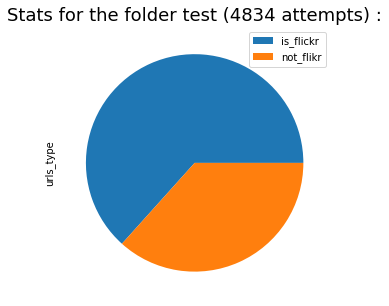

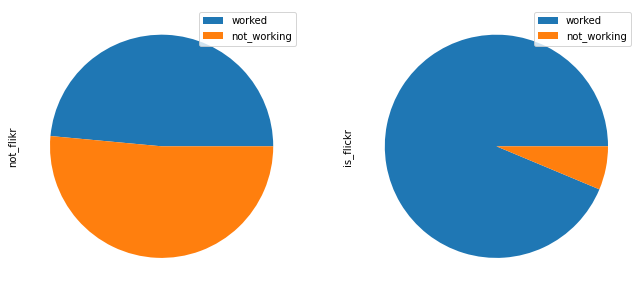

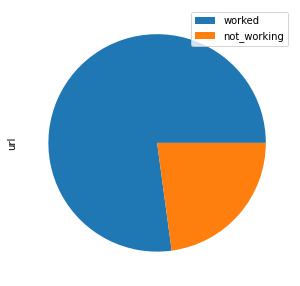

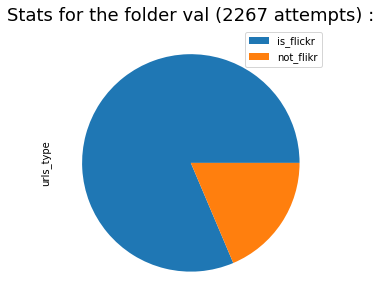

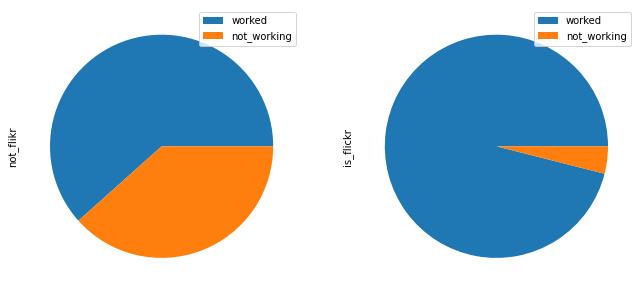

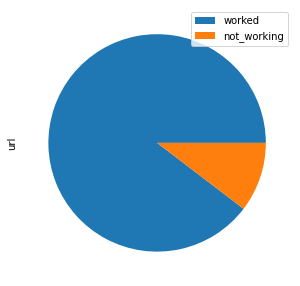

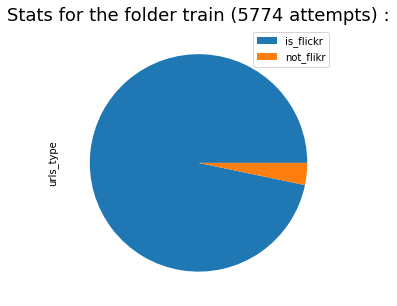

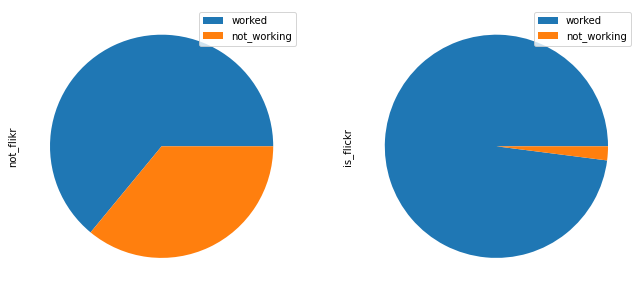

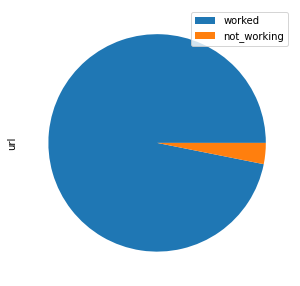

In [9]:
for folder in args.folders : 
    filename = f'results/{datetag}_dataset_{folder}_{args.HOST}.json'
    try:
        df_dataset = pd.read_json(filename)

        df_type = pd.DataFrame({'urls_type': [len(df_dataset[df_dataset['is_flickr']==1]), 
                                              len(df_dataset[df_dataset['is_flickr']==0])]},
                          index=['is_flickr', 'not_flikr'])
        df_flikr = pd.DataFrame({'not_flikr': [df_dataset[df_dataset['is_flickr']==0]['lab_work'].sum(), 
                                               (len(df_dataset[df_dataset['is_flickr']==0]) - df_dataset[df_dataset['is_flickr']==0]['lab_work'].sum())],
                                 'is_flickr': [df_dataset[df_dataset['is_flickr']==1]['lab_work'].sum(), 
                                               (len(df_dataset[df_dataset['is_flickr']==1]) - df_dataset[df_dataset['is_flickr']==1]['lab_work'].sum())]},
                                  index=['worked', 'not_working'])
        df_all = pd.DataFrame({'url': [len(df_dataset[df_dataset['lab_work']==1]), len(df_dataset[df_dataset['lab_work']==0])]},
                          index=['worked', 'not_working'])

        plot_type = df_type.plot.pie(y='urls_type', figsize=(5, 5), labeldistance=None)
        plot_type.set_title('Stats for the folder '+ folder + ' (' + str(len(df_dataset)) + ' attempts) :', size = 18)
        if not len(df_dataset[df_dataset['is_flickr']==0]) == 0 or len(df_dataset[df_dataset['is_flickr']==1]) == 0: 
            plot_flickr = df_flikr.plot.pie(subplots=True, figsize=(11, 6), labeldistance=None)
        plot_all = df_all.plot.pie(y='url', figsize=(5, 5), labeldistance=None)
    except:
        pass # TODO : make something more elegant

## Transfer learning and dataset config

In the `model.py` scrip,t we first define the `transform` functions for the datasets. To perform image augmentation, we apply the pyTorch `AutoAugment` function to the `train` and `val` dataset. Then, we load the pretrained models and store them in memory.

In [10]:
scriptname = 'DCNN_training_benchmark/model.py'

In [11]:
%%writefile {scriptname}

from DCNN_training_benchmark.init import *

import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

import seaborn as sns
import sklearn.metrics
from scipy import stats
from scipy.special import logit, expit

# VGG-16 datasets initialisation
def datasets_transforms(image_size=args.image_size, p=0, num_workers=1, batch_size=args.batch_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'val': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'test': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),
    }
    #print(paths)
    image_datasets = {
        folder: datasets.ImageFolder(
            paths[folder], 
            transform=data_transforms[folder]
        )
        for folder in args.folders
    }

    dataloaders = {
        folder: torch.utils.data.DataLoader(
            image_datasets[folder], batch_size=batch_size,
            shuffle=True, num_workers=num_workers
        )
        for folder in args.folders
    }

    dataset_sizes = {folder: len(image_datasets[folder]) for folder in args.folders}

    return dataset_sizes, dataloaders, image_datasets, data_transforms

(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size)

for folder in args.folders : print(f"Loaded {dataset_sizes[folder]} images under {folder}")
class_names = image_datasets['train'].classes
print("Classes: ", image_datasets['train'].classes)
n_output = len(os.listdir(paths['train']))

Overwriting DCNN_training_benchmark/model.py


In [12]:
ds = datasets.ImageFolder('data/val/')

In [13]:
len(ds)

1972

In [14]:
%run -int {scriptname}

Loaded 3914 images under test
Loaded 1972 images under val
Loaded 5575 images under train
Classes:  ['albatross', 'ant', 'bell pepper', 'computer keyboard', 'cornet', 'king penguin', 'lionfish', 'macaque', 'sewing machine', 'vending machine']

IPython CPU timings (estimated):
  User   :       0.53 s.
  System :       0.26 s.
Wall time:       0.79 s.


<Figure size 432x288 with 0 Axes>

## Training process

Finaly, we implement the training process in `experiment_train.py`, using a classic training script with pyTorch. For further statistical analyses, we extract factors (like the accuracy and loss) within a `pandas` object (a `DataFrame`). 

In [15]:
scriptname = 'experiment_train.py'

In [16]:
%%writefile {scriptname}
from DCNN_training_benchmark.model import *

def train_model(model, num_epochs, lr=args.lr, momentum=args.momentum, log_interval=100):
    
    model.to(device)
    if momentum == 0.:
        optimizer = optim.Adam(model.parameters(), lr=lr)#, betas=(beta1, beta2), amsgrad=amsgrad)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) # to set training variables

    df_train = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val', 'device_type']) 

    for epoch in range(num_epochs):
        loss_train = 0
        acc_train = 0
        for i, (images, labels) in enumerate(dataloaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.item() * images.size(0)
            _, preds = torch.max(outputs.data, 1)
            acc_train += torch.sum(preds == labels.data)
            
        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
           
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            for i, (images, labels) in enumerate(dataloaders['val']):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                loss_val += loss.item() * images.size(0)
                _, preds = torch.max(outputs.data, 1)
                acc_val += torch.sum(preds == labels.data)
        
            avg_loss_val = loss_val / dataset_sizes['val']
            avg_acc_val = acc_val / dataset_sizes['val']
        
        df_train.loc[epoch] = {'epoch':epoch, 'avg_loss':avg_loss, 'avg_acc':float(avg_acc),
                               'avg_loss_val':avg_loss_val, 'avg_acc_val':float(avg_acc_val), 'device_type':device.type}
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")

    model.cpu()
    torch.cuda.empty_cache()
    return model, df_train

criterion = nn.CrossEntropyLoss()

# Training and saving the network

models_vgg = {}
opt = {}
#df_train = {}

models_vgg['vgg'] = torchvision.models.vgg16(pretrained=True)

# Downloading the model
for model_name in args.model_names:
    model_filenames[model_name] = args.model_path + model_name + '.pt'
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'

    models_vgg[model_name] = torchvision.models.vgg16(pretrained=True)
    # Freeze training for all layers
    # Newly created modules have require_grad=True by default
    for param in models_vgg[model_name].features.parameters():
        param.require_grad = False 

    if model_name == 'vgg16_lin':
        num_features = models_vgg[model_name].classifier[-1].out_features
        features = list(models_vgg[model_name].classifier.children())
        features.extend([nn.Linear(num_features, n_output)]) # Adding one layer on top of last layer
        models_vgg[model_name].classifier = nn.Sequential(*features)

    else : 
        num_features = models_vgg[model_name].classifier[-1].in_features
        features = list(models_vgg[model_name].classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, n_output)]) # Add our layer with 10 outputs
        models_vgg[model_name].classifier = nn.Sequential(*features) # Replace the model classifier

    if os.path.isfile(model_filenames[model_name]):
        print("Loading pretrained model for..", model_name, ' from', model_filenames[model_name])
        #print("Resume_training : ", resume_training)

        if device.type == 'cuda':
            models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name])) #on GPU
        else:
            models_vgg[model_name].load_state_dict(torch.load(model_filenames[model_name], map_location=torch.device('cpu'))) #on CPU

    else:
        print("Re-training pretrained model...", model_filenames[model_name])
        since = time.time()

        p = 1 if model_name == 'vgg16_gray' else 0
        if model_name =='vgg16_scale':
            df_train = None
            for image_size_ in image_sizes: # starting with low resolution images 
                print(f"Traning {model_name}, image_size = {image_size_}, p (Grayscale) = {p}")
                (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size_, p=p)
                models_vgg[model_name], df_train_ = train_model(models_vgg[model_name], num_epochs=args.num_epochs)
                df_train = df_train_ if df_train is None else df_train.append(df_train_.reset_index(inplace=True))
        else :
            print(f"Traning {model_name}, image_size = {image_size}, p (Grayscale) = {p}")
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size, p=p)
            models_vgg[model_name], df_train = train_model(models_vgg[model_name], num_epochs=args.num_epochs)
        torch.save(models_vgg[model_name].state_dict(), model_filenames[model_name])
        df_train.to_json(filename)
        elapsed_time = time.time() - since
        print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
        print()
            

Overwriting experiment_train.py


In [17]:
%run -int {scriptname}

Loaded 3914 images under test
Loaded 1972 images under val
Loaded 5575 images under train
Classes:  ['albatross', 'ant', 'bell pepper', 'computer keyboard', 'cornet', 'king penguin', 'lionfish', 'macaque', 'sewing machine', 'vending machine']
Loading pretrained model for.. vgg16_gray  from models/re-trained_vgg16_gray.pt
Loading pretrained model for.. vgg16_lin  from models/re-trained_vgg16_lin.pt
Loading pretrained model for.. vgg16_gen  from models/re-trained_vgg16_gen.pt
Loading pretrained model for.. vgg16_scale  from models/re-trained_vgg16_scale.pt

IPython CPU timings (estimated):
  User   :       6.15 s.
  System :       2.93 s.
Wall time:       7.34 s.


Here we display both average accuracy and loss during the training phase and during the validation one : 

In [18]:
filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
%ls {filename}

results/2021-10-10_inv-ope-de06_train_vgg16_scale.json


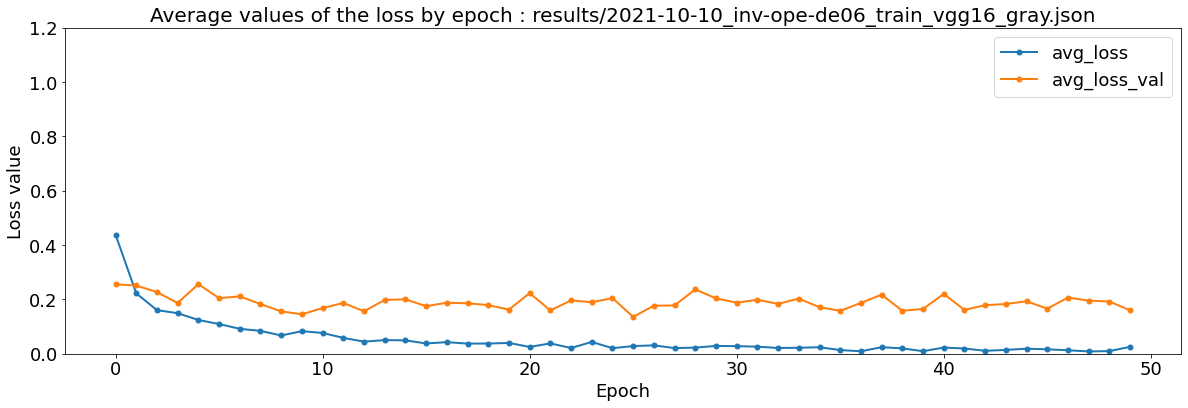

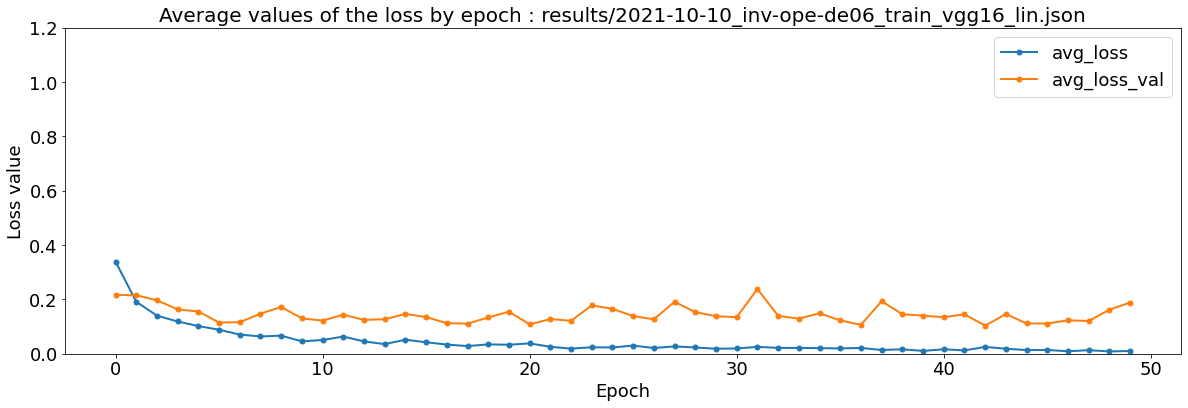

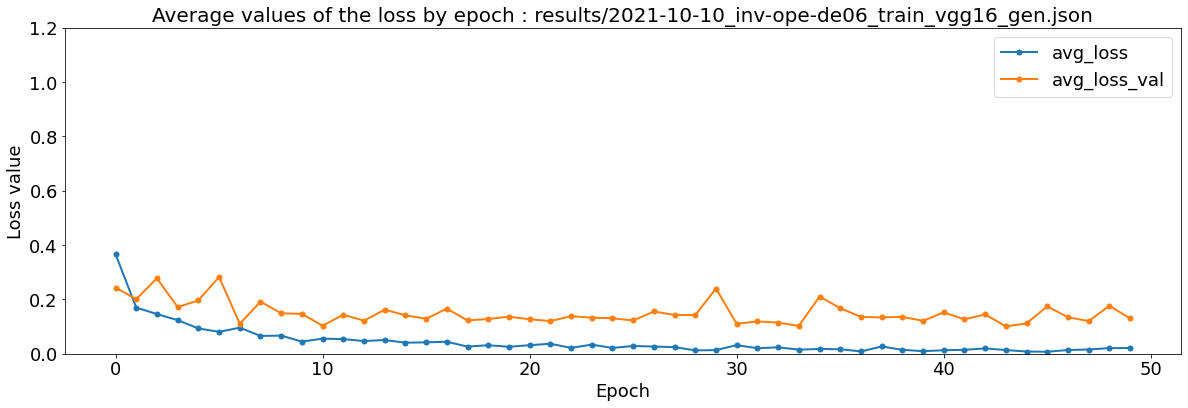

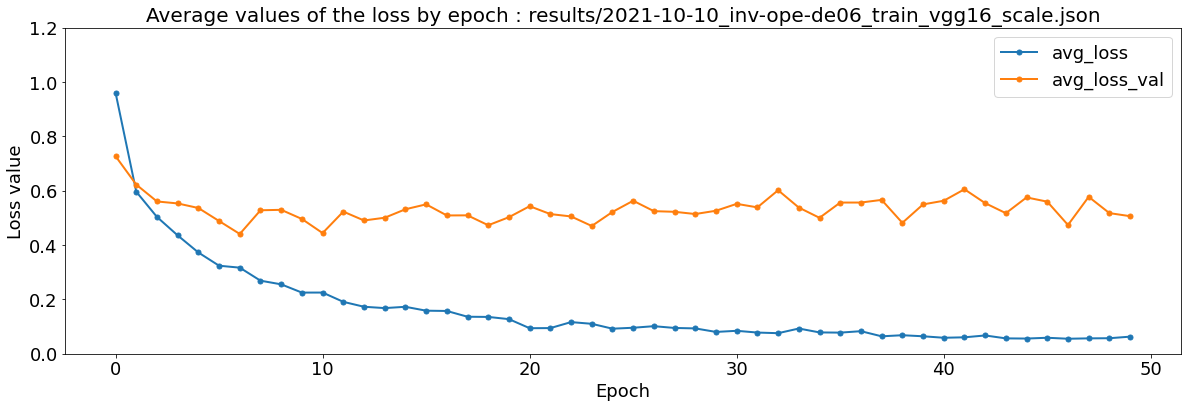

In [19]:
for model_name in args.model_names:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi//2))
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)
    ax = df_train['avg_loss'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_loss_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_loss", "avg_loss_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.set_ylabel("Loss value", size=18)
    ax.set_ylim(0, 1.2)
    axs.set_title(f'Average values of the loss by epoch : {filename}' , size = 20)

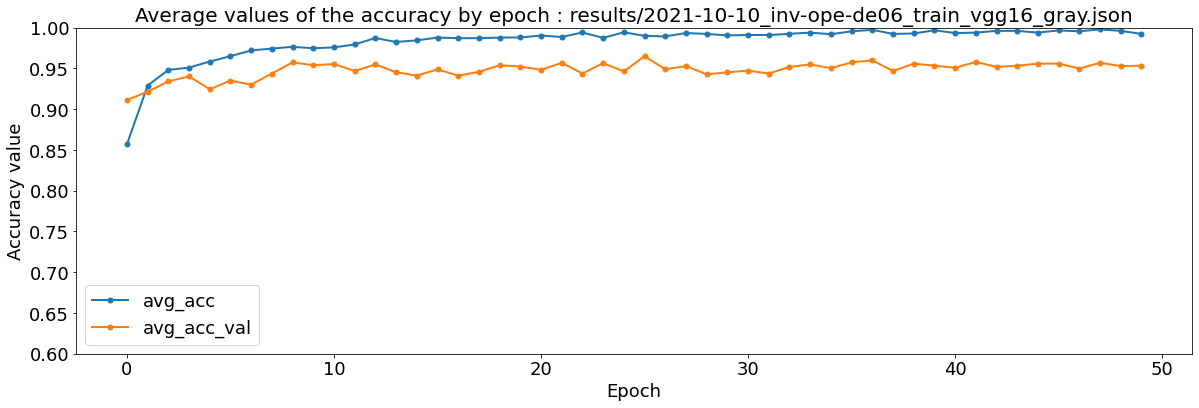

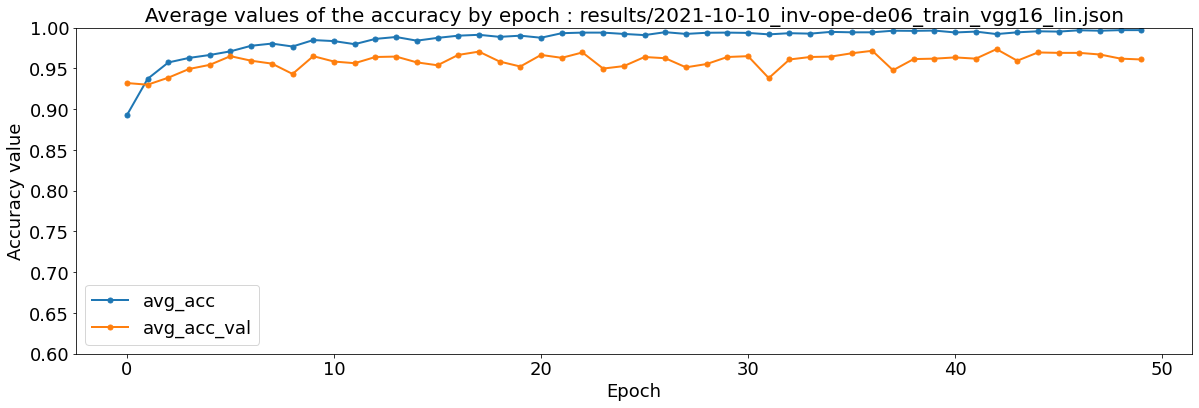

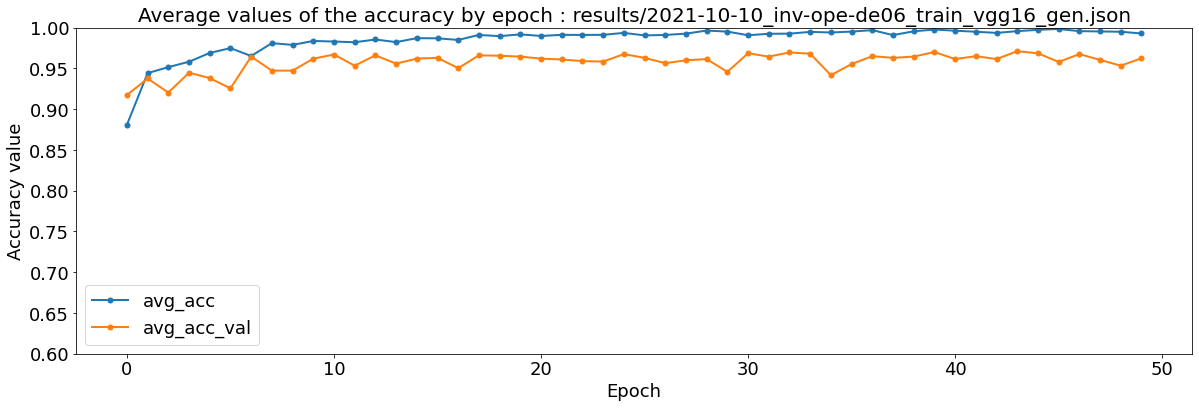

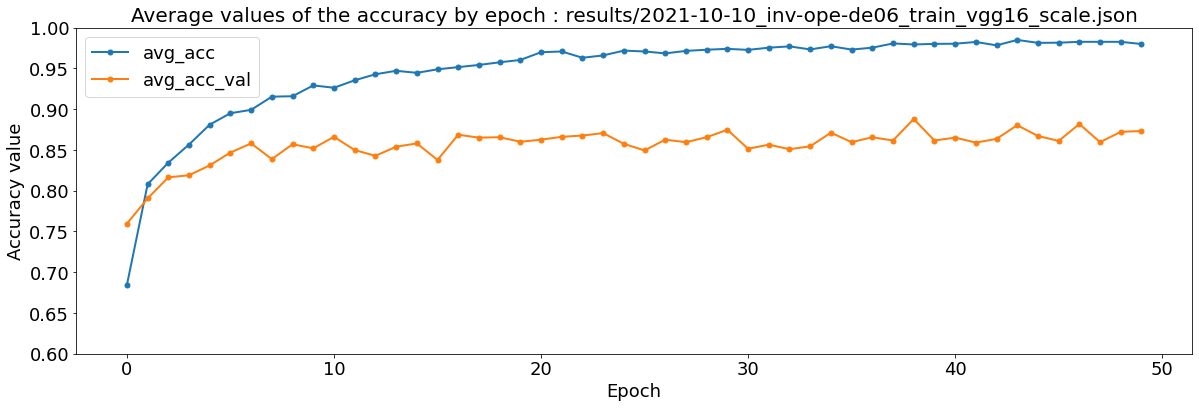

In [20]:
for model_name in args.model_names:
    filename = f'results/{datetag}_{args.HOST}_train_{model_name}.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi//2))
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)
    ax = df_train['avg_acc'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_acc_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_acc", "avg_acc_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.set_ylabel("Accuracy value", size=18)
    ax.set_ylim(0.60, 1)
    axs.set_title(f'Average values of the accuracy by epoch : {filename}' , size = 20)

# Experiment 1: Image processing and recognition for differents labels 


The networks are now ready for a quantitative evaluation. The second part of this notebook offers a comparison between : 

- A pre-trained image recognition's networks, here VGG, trained on the [Imagenet](http://image-net.org/) dataset wich allows to work on naturals images for $1000$ labels, taken from the `torchvision.models` library

- And four re-trained version of the same network VGG16 based on a reduced Imagenet dataset wich allows to focus on naturals images from $10$ labels.

For further statistical analyses, we extract these differents factors (like the accuracy and the processing time for differents datasets at differents resolution) in a `pandas` object. 

In [21]:
scriptname = 'experiment_basic.py'

In [22]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_training_benchmark.model import *
#from experiment_train import *
filename = f'results/{datetag}_results_1_{args.HOST}.json'

def main():
    try:
        df = pd.read_json(filename)
    except:
        df = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device_type', 'top_1']) 
        i_trial = 0
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size, batch_size=1)
        i_label_top = reverse_labels[image_datasets['test'].classes[label]]
        
        for i_image, (data, label) in enumerate(dataloaders['test']):
            data, label = data.to(device), label.to(device)
            for model_name in models_vgg.keys():
                model = models_vgg[model_name]
                model = model.to(device)
                tic = time.time()

                with torch.no_grad():
                    out = model(data).squeeze(0)
                    _, indices = torch.sort(out, descending=True)
                    if model_name == 'vgg' : # our previous work
                        top_1 = labels[indices[0]]
                        percentage = torch.nn.functional.softmax(out[args.i_labels], dim=0) * 100
                        perf_ = percentage[reverse_i_labels[i_label_top]].item()
                    else :
                        top_1 = reverse_model_labels[indices[0]] 
                        percentage = torch.nn.functional.softmax(out, dim=0) * 100
                        perf_ = percentage[label].item()
                
                elapsed_time = time.time() - tic
                print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {elapsed_time:.3f} seconds, best confidence for : {top_1}')
                df.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':elapsed_time, 'fps': 1/elapsed_time,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'device_type':device.type, 'top_1':top_1}
                i_trial += 1
        df.to_json(filename)

if __name__ == "__main__":
    main()    

Overwriting experiment_basic.py


In [23]:
%run -int {scriptname}


IPython CPU timings (estimated):
  User   :       0.00 s.
  System :       0.00 s.
Wall time:       0.00 s.


<Figure size 432x288 with 0 Axes>

Here we collect our results, we can already display all the data in a table 

In [24]:
%ls results/2021-10-10_results_1_inv-ope-de06.json

results/2021-10-10_results_1_inv-ope-de06.json


In [25]:
%ls results/2021-10-10*

results/2021-10-10_config_args.json
results/2021-10-10_dataset_test_inv-ope-de06.json
results/2021-10-10_dataset_train_inv-ope-de06.json
results/2021-10-10_dataset_val_inv-ope-de06.json
results/2021-10-10_inv-ope-de06_train_vgg16_gen.json
results/2021-10-10_inv-ope-de06_train_vgg16_gray.json
results/2021-10-10_inv-ope-de06_train_vgg16_lin.json
results/2021-10-10_inv-ope-de06_train_vgg16_scale.json
results/2021-10-10_results_1_inv-ope-de06.json
results/2021-10-10_results_2_inv-ope-de06.json
results/2021-10-10_results_3_inv-ope-de06.json


In [26]:
filename = f'results/{datetag}_results_1_{args.HOST}.json'
df = pd.read_json(filename)
df

model        perf         fps      time      label  i_label  \
0              vgg   98.852501  108.265249  0.009237  albatross      146   
1       vgg16_gray  100.000000  192.797242  0.005187  albatross      146   
2        vgg16_lin   99.993752  219.493642  0.004556  albatross      146   
3        vgg16_gen   99.991035  218.897970  0.004568  albatross      146   
4      vgg16_scale  100.000000  226.621137  0.004413  albatross      146   
...            ...         ...         ...       ...        ...      ...   
19565          vgg   99.942055  233.874428  0.004276     cornet      513   
19566   vgg16_gray  100.000000  240.058608  0.004166     cornet      513   
19567    vgg16_lin   99.937096  238.882788  0.004186     cornet      513   
19568    vgg16_gen   99.999985  241.246060  0.004145     cornet      513   
19569  vgg16_scale  100.000000  240.499083  0.004158     cornet      513   

       i_image                                  filename device_type  \
0            0             data/test/albatross/01771.jpg        cuda   
1            0             data/test/albatross/01771.jpg        cuda   
2            0             data/test/albatross/01771.jpg        cuda   
3            0             data/test/albatross/01771.jpg        cuda   
4            0             data/test/albatross/01771.jpg        cuda   
...        ...                                       ...         ...   
19565     3913  data/test/vending machine/yonaturals.jpg        cuda   
19566     3913  data/test/vending machine/yonaturals.jpg        cuda   
19567     3913  data/test/vending machine/yonaturals.jpg        cuda   
19568     3913  data/test/vending machine/yonaturals.jpg        cuda   
19569     3913  data/test/vending machine/yonaturals.jpg        cuda   

           top_1  
0      albatross  
1      albatross  
2      albatross  
3      albatross  
4      albatross  
...          ...  
19565     cornet  
19566     cornet  
19567     cornet  
19568     cornet  
19569     cornet  

[19570 rows x 10 columns]

## Accuracy, Precision, Recall

Here we are displaying the acuracy top 1 (wich is a metric that generally describes how the model performs across all classes, here top 1 because we only take the best likelihood at the exit of the networks), the precision (which reflects how reliable the model is in classifying samples as Positive) and the recall (which measures the model's ability to detect Positive samples) of each networks. We decided to use the [sklearn librairy](https://sklearn.org/index.html) to perform this [analysis](https://blog.paperspace.com/deep-learning-metrics-precision-recall-accuracy/)

In [27]:
reverse_model_labels

['albatross',
 'ant',
 'bell pepper',
 'computer keyboard',
 'cornet',
 'king penguin',
 'lionfish',
 'macaque',
 'sewing machine',
 'vending machine']

In [28]:
models_vgg.keys()

dict_keys(['vgg', 'vgg16_gray', 'vgg16_lin', 'vgg16_gen', 'vgg16_scale'])

<ipython-input-29-3b93b2728205>:21: RuntimeWarning: invalid value encountered in long_scalars
  pres_ = (pres_[0][0]) / (pres_[0][0] + pres_[0][-1])


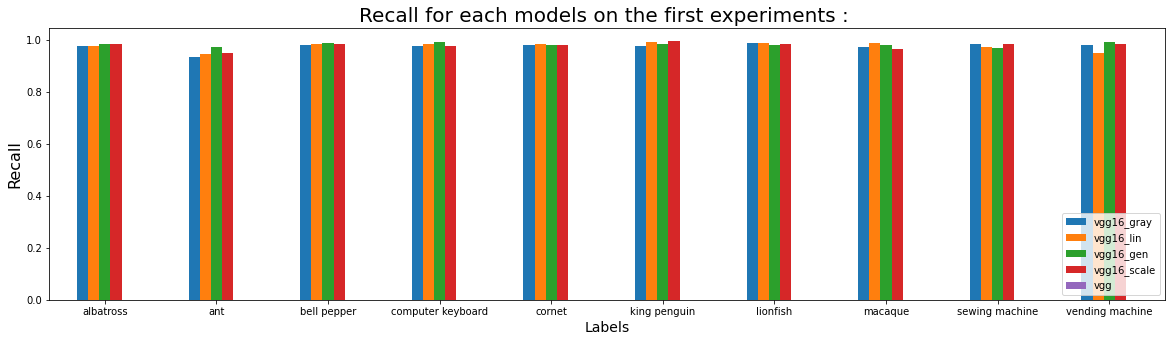

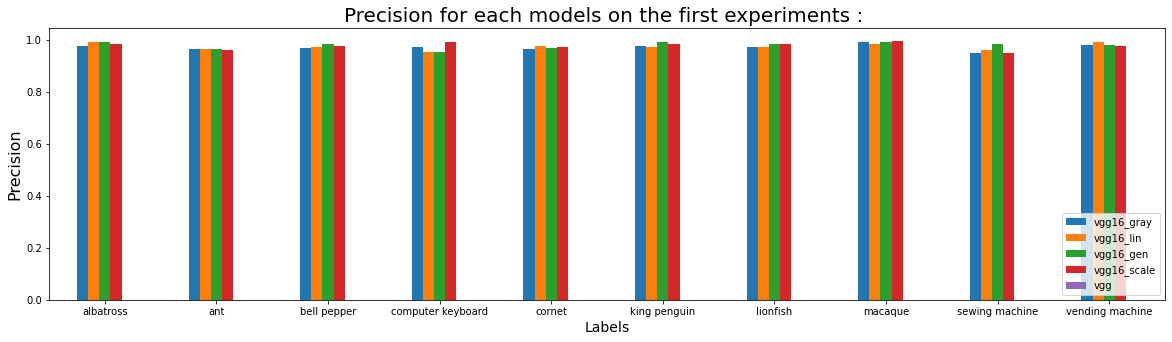

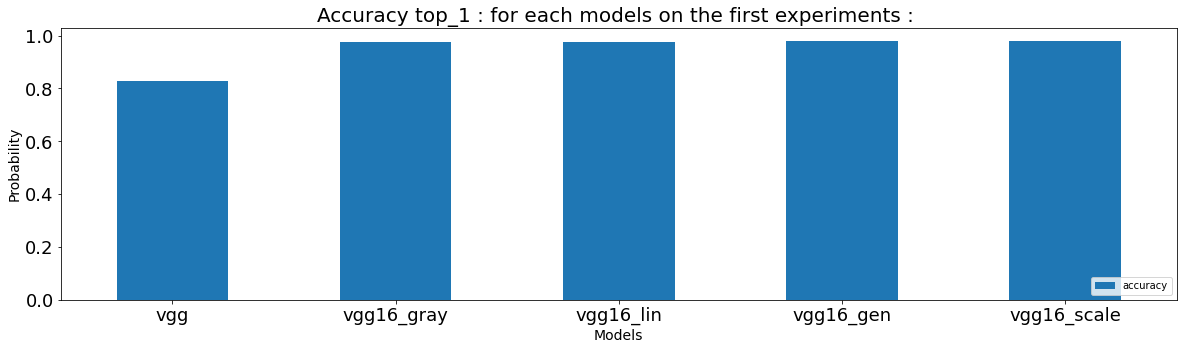

In [29]:
results = {} 
results['acc'] = []
results['precision'] = {}
results['recall'] = {}

for model_name in models_vgg.keys() :
    model_pred = df[df['model']==model_name]["top_1"].values.tolist()
    ground_truth = df[df['model']==model_name]["label"].values.tolist()
    acc = sklearn.metrics.accuracy_score(ground_truth, model_pred)
    results['acc'].append(acc)
    pres = sklearn.metrics.multilabel_confusion_matrix(ground_truth, model_pred)
    results['precision'][model_name] = []
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[-1][0]))
        #print('precision : ' , pres_)
        results['precision'][model_name].append(pres_)
    results['recall'][model_name] = []
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = (pres_[0][0]) / (pres_[0][0] + pres_[0][-1])
        #print('recall : ' , pres_)
        results['recall'][model_name].append(pres_)

for mode in ['recall', 'precision']:
    df_acc = pd.DataFrame({'vgg16_gray': results[mode]['vgg16_gray'],
                           'vgg16_lin': results[mode]['vgg16_lin'],
                           'vgg16_gen': results[mode]['vgg16_gen'],
                           'vgg16_scale': results[mode]['vgg16_scale'],
                           'vgg': results[mode]['vgg']}, index=reverse_model_labels)
    ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
    ax.set_title(mode.capitalize()+' for each models on the first experiments : ', size=20)
    ax.set_ylabel(mode.capitalize(), size=16)
    ax.set_xlabel('Labels', size=14)
    plt.legend(loc='lower right')

df_acc = pd.DataFrame({'accuracy': results['acc']},
                  index = models_vgg.keys())

ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize=18)
plt.legend(loc='lower right')
ax.set_title('Accuracy top_1 : for each models on the first experiments : ', size=20)
ax.set_ylabel('Probability', size=14)
ax.set_xlabel('Models', size=14);

## Computation time

A display of the differents computation time of each models on the same dataset for the sequence of trials :

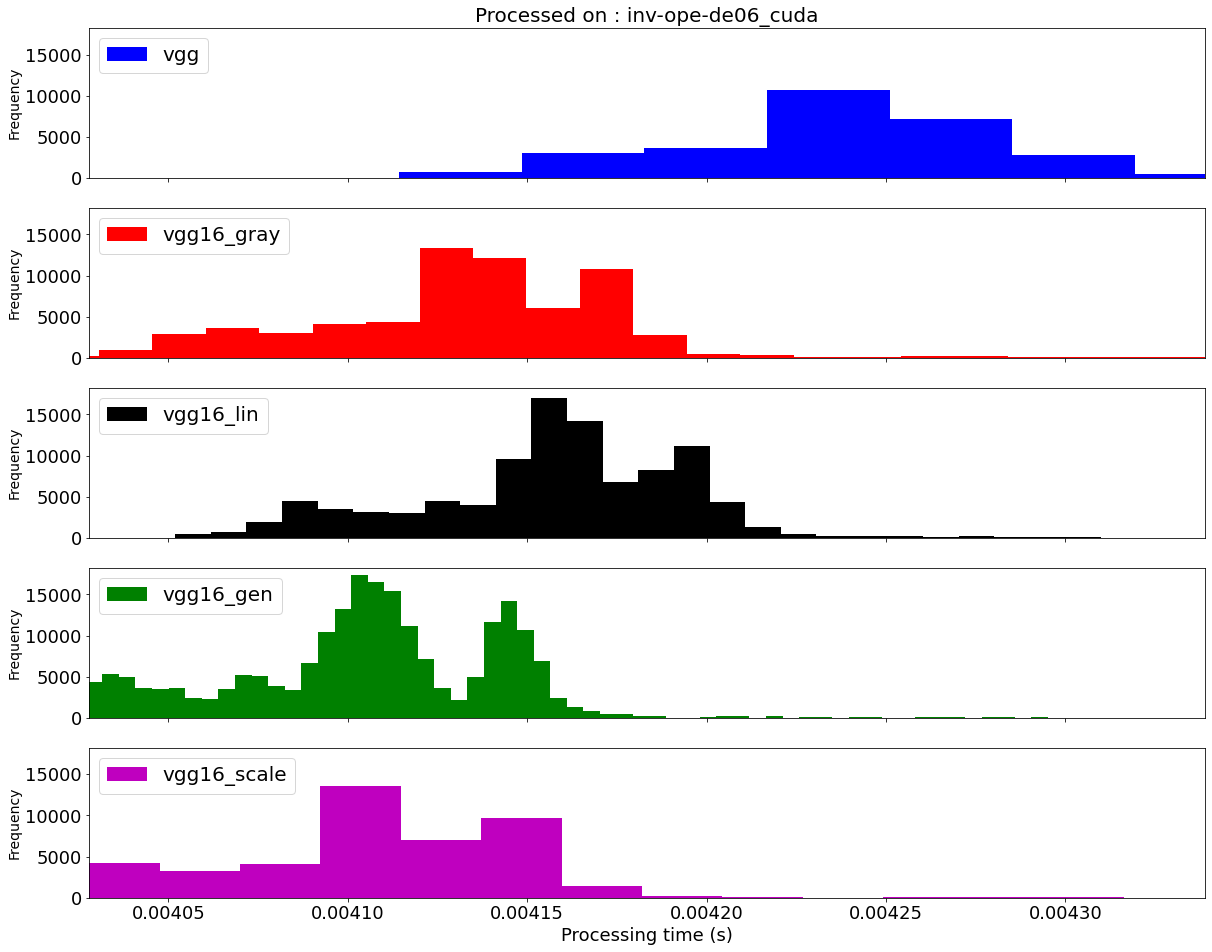

In [30]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2), sharex=True, sharey=True)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models_vgg.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df[df['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=model_name,ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlim(df['time'].quantile(.01), df['time'].quantile(.99))
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## Classification likelihood

This graph shows the frequency of the logit of the classification likelihood for our four models and the pyTorch VGG16 model. The classification likelihood represent a probability of detection for a given label at the output of the network. As most of them are close either to 100 as to 0, we applied a logit function to make the difference between these networks more obvious.

TODO voir si on peut donner la valeur du logit en hartley base 10 https://en.wikipedia.org/wiki/Hartley_(unit) tracer le chance level

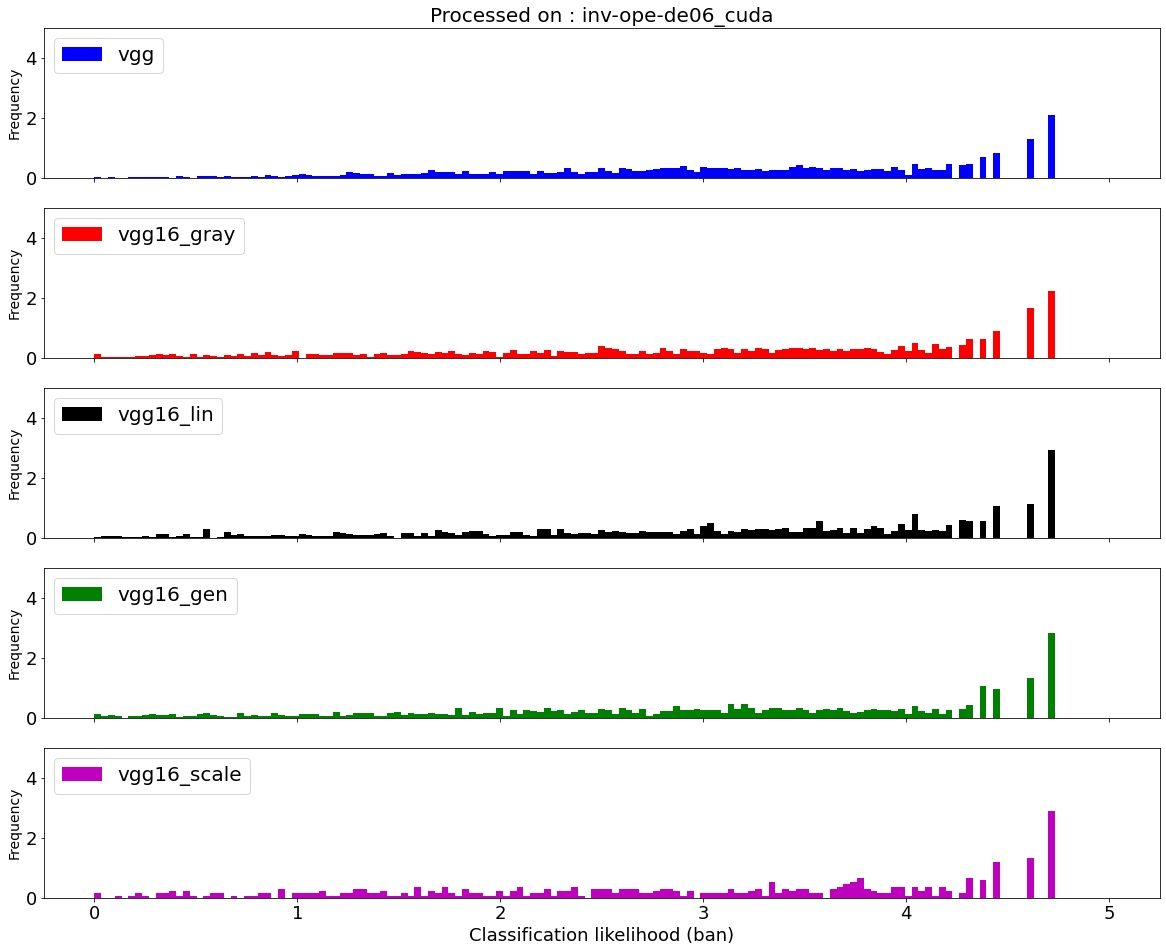

In [31]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2), sharex=True, sharey=True)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models_vgg.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    (logit(df[df['model']==model_name]['perf']/100)/np.log2(10)).plot.hist(bins=np.linspace(0, 5, 150), lw=1, label=model_name, ax=ax, color=color, density=True)
    #df[df['model']==model_name]['perf'].plot.hist(bins=np.linspace(99.95, 100, 150), lw=1, label=model_name, ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize=20)
    ax.set_ylim(0, 5)
    # ax.tick_params(axis='x', labelsize=14)
    # ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification likelihood (ban)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## Image display

Here we display the 64 *worsts* Classification likelihood's, all model combined : 

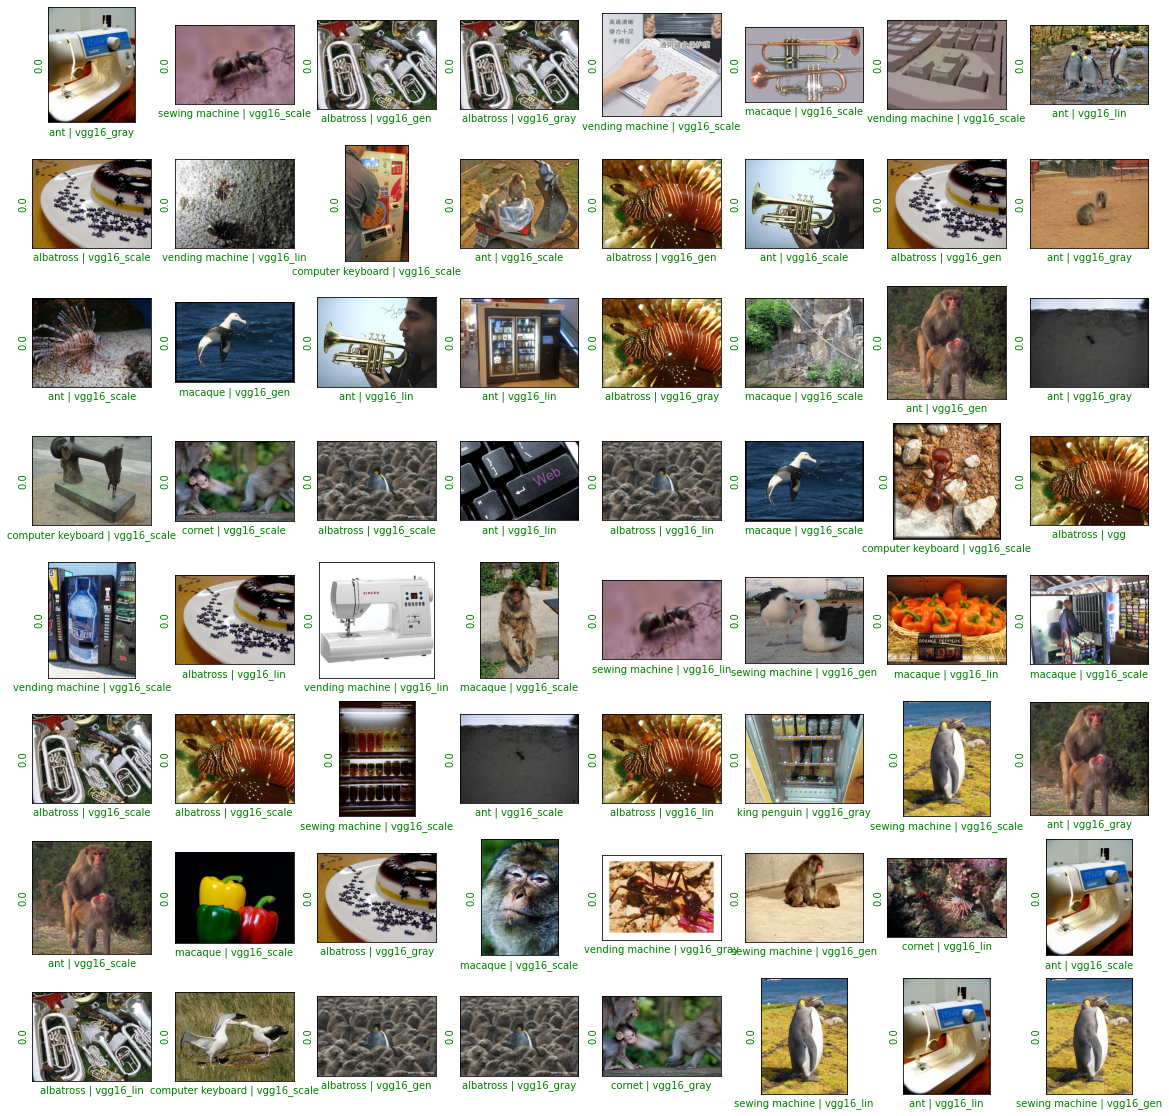

In [32]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width, fig_width))
for i, idx in enumerate(df["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df.loc[idx]['label'] + ' | ' + df.loc[idx]['model'], color='g')
    perf_ = df.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')

## summary

To make it even clearer we extracted a specific mean for each models : 

Mean accuracy

In [33]:
for model_name in models_vgg.keys():
    mean_acc = (df[df['model']==model_name]["top_1"] == df[df['model']==model_name]["label"]).mean()
    print(f'For the {model_name} model, the mean accuracy = {mean_acc*100:.4f} %' )

For the vgg model, the mean accuracy = 82.8053 %
For the vgg16_gray model, the mean accuracy = 97.3684 %
For the vgg16_lin model, the mean accuracy = 97.5473 %
For the vgg16_gen model, the mean accuracy = 98.0583 %
For the vgg16_scale model, the mean accuracy = 97.8028 %


Classification likelihood's mean

In [34]:
for model_name in models_vgg.keys():
    med_perf = np.mean(df[df['model']==model_name]["perf"])
    print(f'For the {model_name} model, the mean clasification likelihood = {med_perf:.4f} %' )

For the vgg model, the mean clasification likelihood = 98.6665 %
For the vgg16_gray model, the mean clasification likelihood = 97.1219 %
For the vgg16_lin model, the mean clasification likelihood = 97.3077 %
For the vgg16_gen model, the mean clasification likelihood = 97.5287 %
For the vgg16_scale model, the mean clasification likelihood = 97.8028 %


Computation time 's mean

In [35]:
for model_name in models_vgg.keys():
    med_perf = np.mean(df[df['model']==model_name]["time"])
    print(f'For the {model_name} model, the mean computation time = {med_perf:.5f} s')

For the vgg model, the mean computation time = 0.00425 s
For the vgg16_gray model, the mean computation time = 0.00414 s
For the vgg16_lin model, the mean computation time = 0.00416 s
For the vgg16_gen model, the mean computation time = 0.00410 s
For the vgg16_scale model, the mean computation time = 0.00411 s


Frame per second's mean

In [36]:
for model_name in models_vgg.keys():
    med_perf = np.mean(df[df['model']==model_name]["fps"])
    print(f'For the {model_name} model, the mean fps = {med_perf:.3f} Hz' )

For the vgg model, the mean fps = 235.560 Hz
For the vgg16_gray model, the mean fps = 241.620 Hz
For the vgg16_lin model, the mean fps = 240.422 Hz
For the vgg16_gen model, the mean fps = 243.647 Hz
For the vgg16_scale model, the mean fps = 243.383 Hz


# Experiment 2: Image processing and recognition for differents resolutions :

Let's now study that same likelihood indicators at different image resolutions.

In [37]:
scriptname = 'experiment_downsample.py'

In [38]:
%%writefile {scriptname}
#import model's script and set the output file
from DCNN_training_benchmark.model import *
filename = f'results/{datetag}_results_2_{args.HOST}.json'

def main():

    # Output's set up
    try:
        df_downsample = pd.read_json(filename)
    except:
        df_downsample = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'image_size', 'filename', 'device_type', 'top_1']) 
        i_trial = 0

        # image preprocessing
        for image_size_ in image_sizes:
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size_, batch_size=1)
            print(f'Résolution de {image_size_=}')
            i_label_top = reverse_labels[image_datasets['test'].classes[label]]
            # Displays the input image of the model 
            for i_image, (data, label) in enumerate(dataloaders['test']):
                data, label = data.to(device), label.to(device)

                for model_name in models_vgg.keys():
                    model = models_vgg[model_name]
                    model = model.to(device)

                    with torch.no_grad():
                        tic = time.time()
                        out = model(data).squeeze(0)
                        _, indices = torch.sort(out, descending=True)
                        if model_name == 'vgg' : # our previous work
                            top_1 = labels[indices[0]]
                            percentage = torch.nn.functional.softmax(out[args.i_labels], dim=0) * 100
                            perf_ = percentage[reverse_i_labels[i_label_top]].item()
                        else :
                            top_1 = reverse_model_labels[indices[0]] 
                            percentage = torch.nn.functional.softmax(out, dim=0) * 100
                            perf_ = percentage[label].item()
                    dt = time.time() - tic
                    df_downsample.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                       'label':labels[i_label_top], 'i_label':i_label_top, 
                                       'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'image_size': image_size_, 'device_type':device.type, 'top_1':str(top_1)}
                    print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds, best confidence for : {top_1}')
                    i_trial += 1
            df_downsample.to_json(filename)

if __name__ == "__main__":
    main()            

Overwriting experiment_downsample.py


In [39]:
%run -int {scriptname}


IPython CPU timings (estimated):
  User   :       0.00 s.
  System :       0.00 s.
Wall time:       0.01 s.


<Figure size 432x288 with 0 Axes>

Here, again, we collect our results, and display all the data in a table 

In [40]:
filename = f'results/{datetag}_results_2_{args.HOST}.json'
#filename = 'results/2021-04-20_results_2_INV-133-DE01.json'
df_downsample = pd.read_json(filename)
df_downsample

model        perf         fps      time         label  i_label  \
0              vgg   67.171021  231.473731  0.004320        cornet      513   
1       vgg16_gray   78.983017  352.018800  0.002841        cornet      513   
2        vgg16_lin   99.999825  364.785528  0.002741        cornet      513   
3        vgg16_gen   81.501457  377.831186  0.002647        cornet      513   
4      vgg16_scale   95.816391  379.197541  0.002637        cornet      513   
...            ...         ...         ...       ...           ...      ...   
78275          vgg   99.994492   82.824273  0.012074  king penguin      145   
78276   vgg16_gray   99.999962   83.236833  0.012014  king penguin      145   
78277    vgg16_lin  100.000000   83.111481  0.012032  king penguin      145   
78278    vgg16_gen  100.000000   83.392397  0.011992  king penguin      145   
78279  vgg16_scale  100.000000   83.253355  0.012012  king penguin      145   

       i_image  image_size                                  filename  \
0            0          64             data/test/albatross/01771.jpg   
1            0          64             data/test/albatross/01771.jpg   
2            0          64             data/test/albatross/01771.jpg   
3            0          64             data/test/albatross/01771.jpg   
4            0          64             data/test/albatross/01771.jpg   
...        ...         ...                                       ...   
78275     3913         512  data/test/vending machine/yonaturals.jpg   
78276     3913         512  data/test/vending machine/yonaturals.jpg   
78277     3913         512  data/test/vending machine/yonaturals.jpg   
78278     3913         512  data/test/vending machine/yonaturals.jpg   
78279     3913         512  data/test/vending machine/yonaturals.jpg   

      device_type         top_1  
0            cuda    volleyball  
1            cuda        cornet  
2            cuda        cornet  
3            cuda        cornet  
4            cuda        cornet  
...           ...           ...  
78275        cuda  king penguin  
78276        cuda  king penguin  
78277        cuda  king penguin  
78278        cuda  king penguin  
78279        cuda  king penguin  

[78280 rows x 11 columns]

## Accuracy, Precision, Recall

And extract the accuracy, the precision ans the recall for each networks :

<ipython-input-41-b66f39608249>:25: RuntimeWarning: invalid value encountered in long_scalars
  pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))


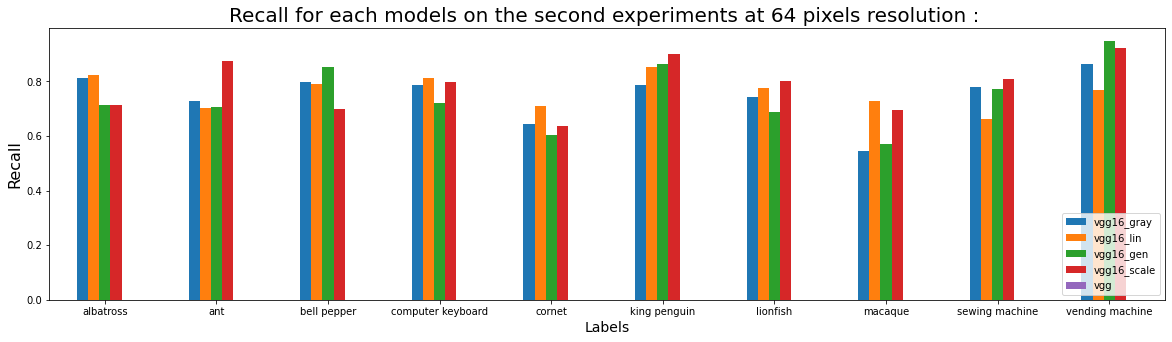

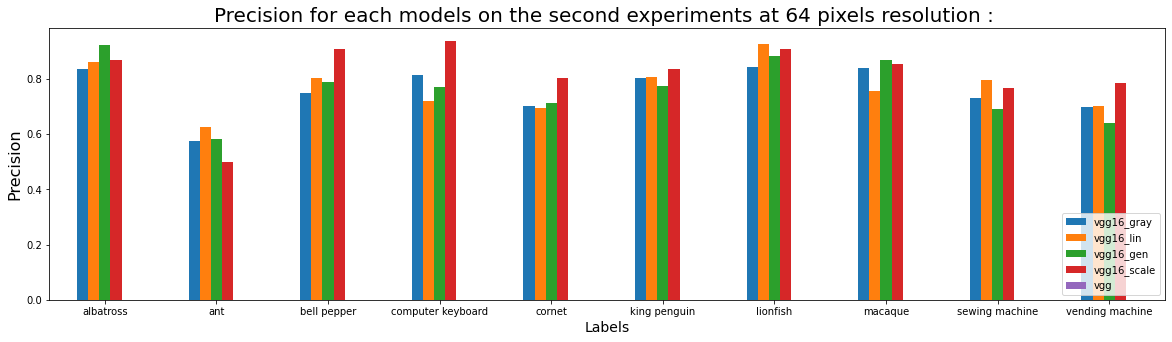

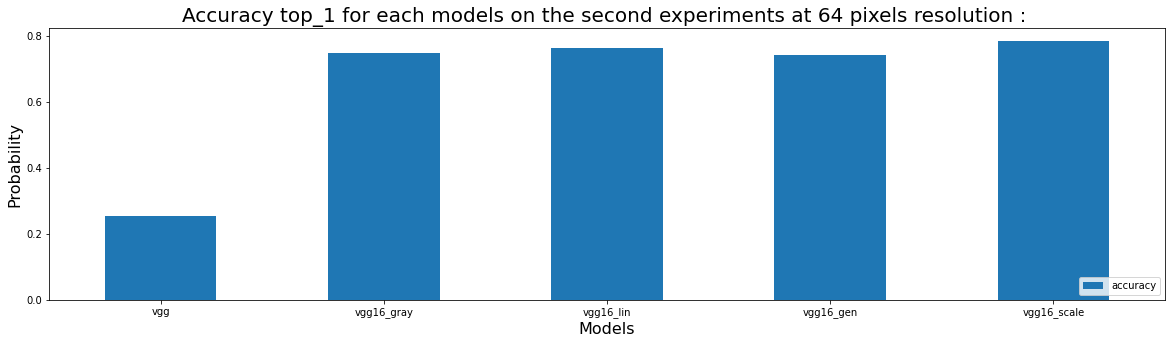

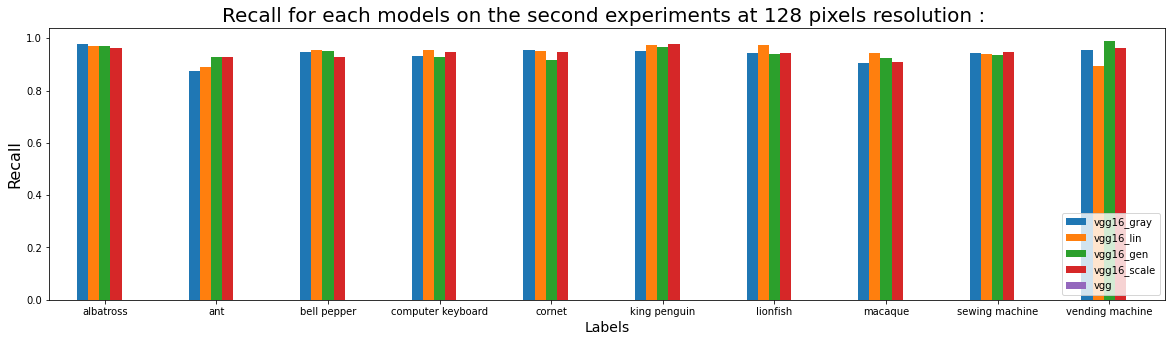

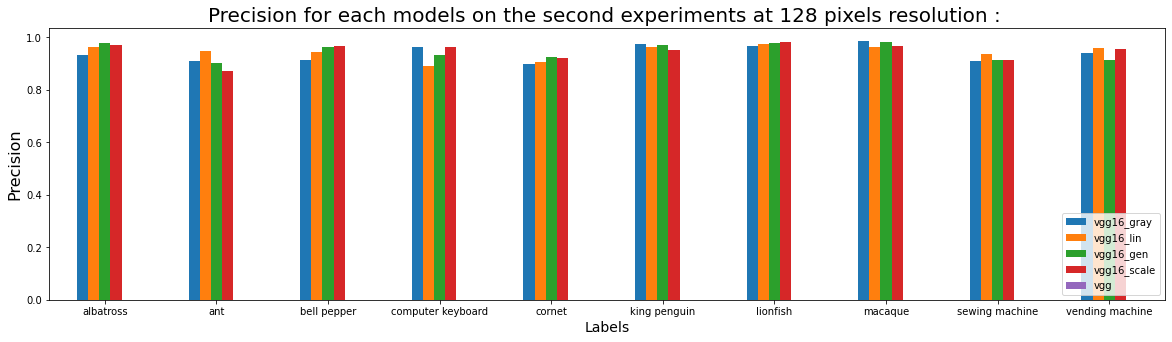

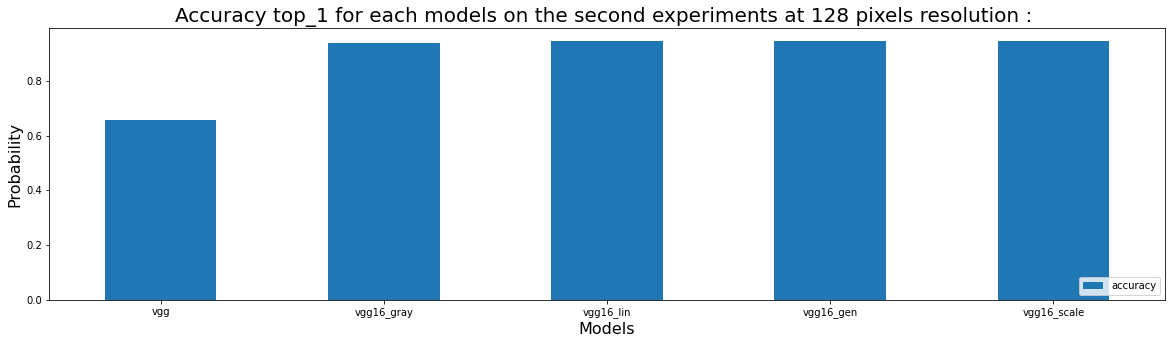

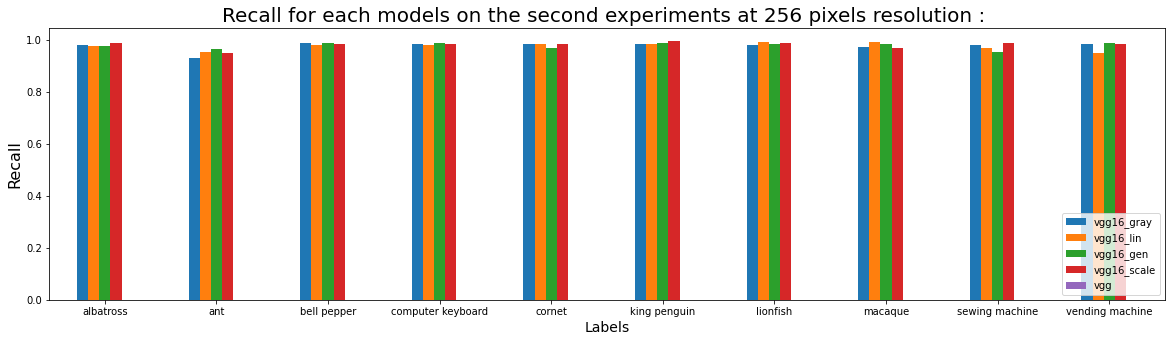

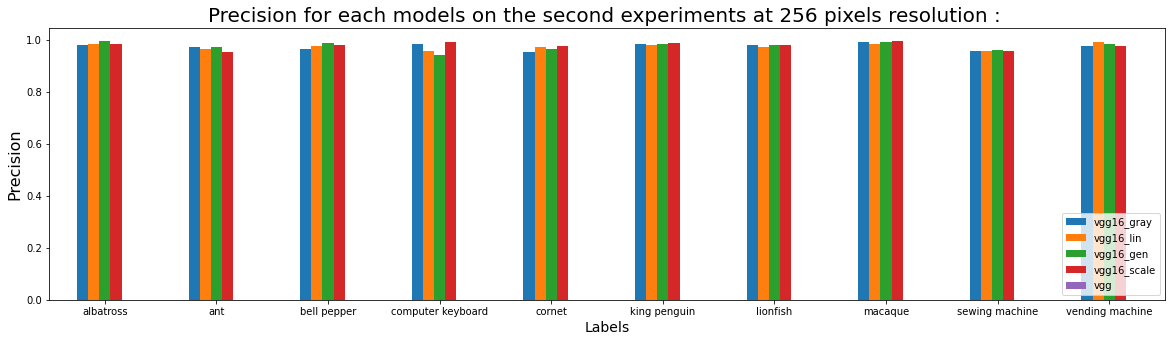

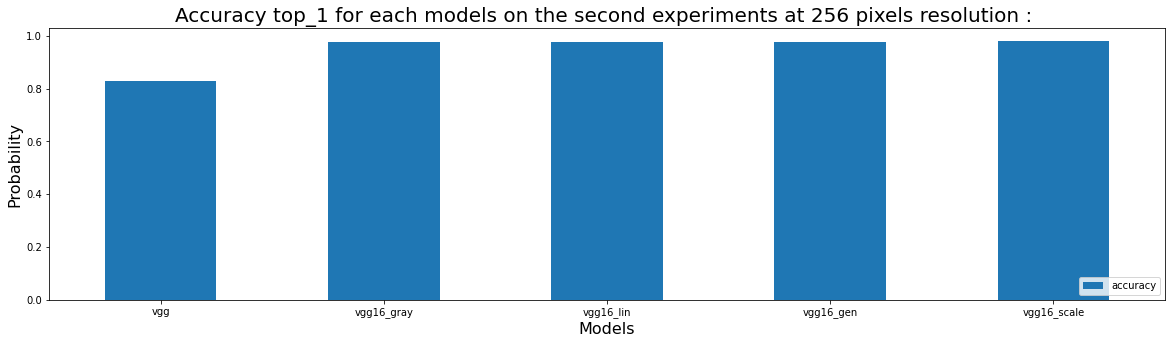

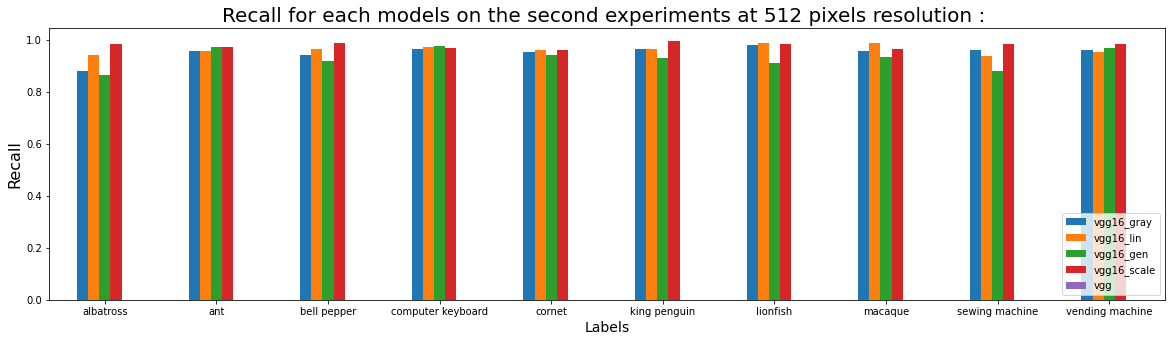

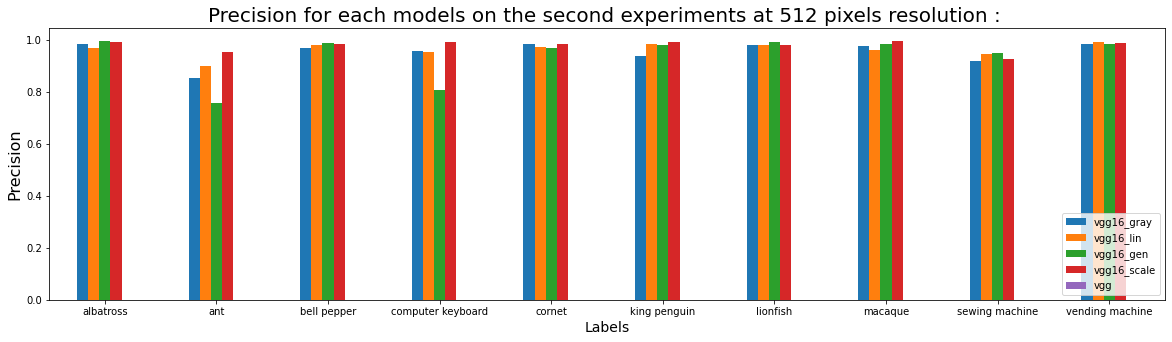

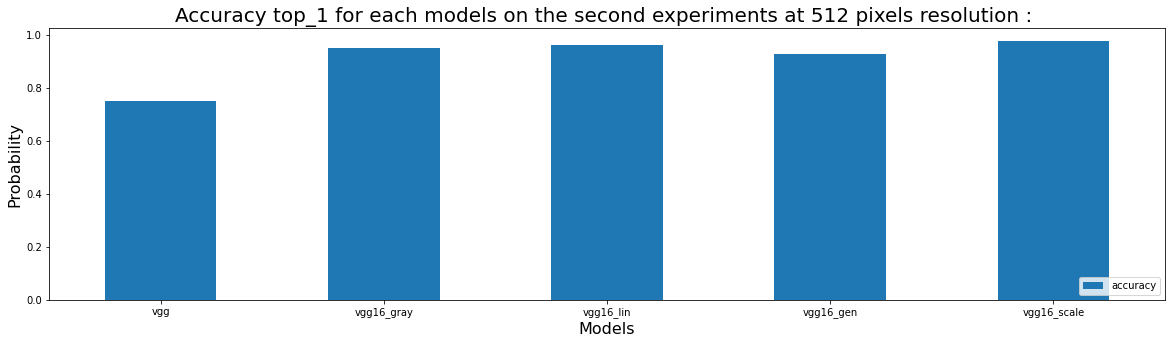

In [41]:
results = {} 
for image_size in image_sizes:
    results[str(image_size)] = {}
    results[str(image_size)]['acc'] = []
    results[str(image_size)]['precision'] = {}
    results[str(image_size)]['recall'] = {}
    for model_name in models_vgg.keys() :
        model_pred = df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["top_1"]
        ground_truth = df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["label"]
        acc = sklearn.metrics.accuracy_score(ground_truth, model_pred)
        results[str(image_size)]['acc'].append(acc)
        #print(f'Accuracy top_1 : {acc:.3f}')
        pres = sklearn.metrics.multilabel_confusion_matrix(ground_truth, model_pred)
        results[str(image_size)]['precision'][model_name] = []
        #pprint('Precision :')
        for i, label in zip(pres, reverse_model_labels) :
            pres_ = np.flip(i)
            pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[-1][0]))
            results[str(image_size)]['precision'][model_name].append(pres_)
            #print(f'{pres_:.3f} for the label {label}')
        results[str(image_size)]['recall'][model_name] = []
        #pprint('Recall :')
        for i, label in zip(pres, reverse_model_labels) :
            pres_ = np.flip(i)
            pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))
            results[str(image_size)]['recall'][model_name].append(pres_)
            #print(f'{pres_:.3f} for the label {label}')

    for mode in ['recall', 'precision']:
        df_acc = pd.DataFrame({'vgg16_gray': results[str(image_size)][mode]['vgg16_gray'],
                               'vgg16_lin': results[str(image_size)][mode]['vgg16_lin'],
                               'vgg16_gen': results[str(image_size)][mode]['vgg16_gen'],
                               'vgg16_scale': results[str(image_size)][mode]['vgg16_scale'],
                               'vgg': results[str(image_size)][mode]['vgg'],
                          }, index=reverse_model_labels)
        ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
        ax.set_title(mode.capitalize()+' for each models on the second experiments at ' + str(image_size) + ' pixels resolution : ', size=20)
        ax.set_ylabel(mode.capitalize(), size=16)
        ax.set_xlabel('Labels', size=14)
        plt.legend(loc='lower right')
        
    df_acc = pd.DataFrame({'accuracy': results[str(image_size)]['acc']},
                      index = models_vgg.keys())
    ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
    ax.set_title(str('Accuracy top_1 for each models on the second experiments at ' + str(image_size) + ' pixels resolution : ') , size=20)
    ax.set_ylabel('Probability', size=16)
    ax.set_xlabel('Models', size=16)
    plt.legend(loc='lower right');

## Computation time

A display of the differents computation time of each models on the same dataset for differents resolutions :

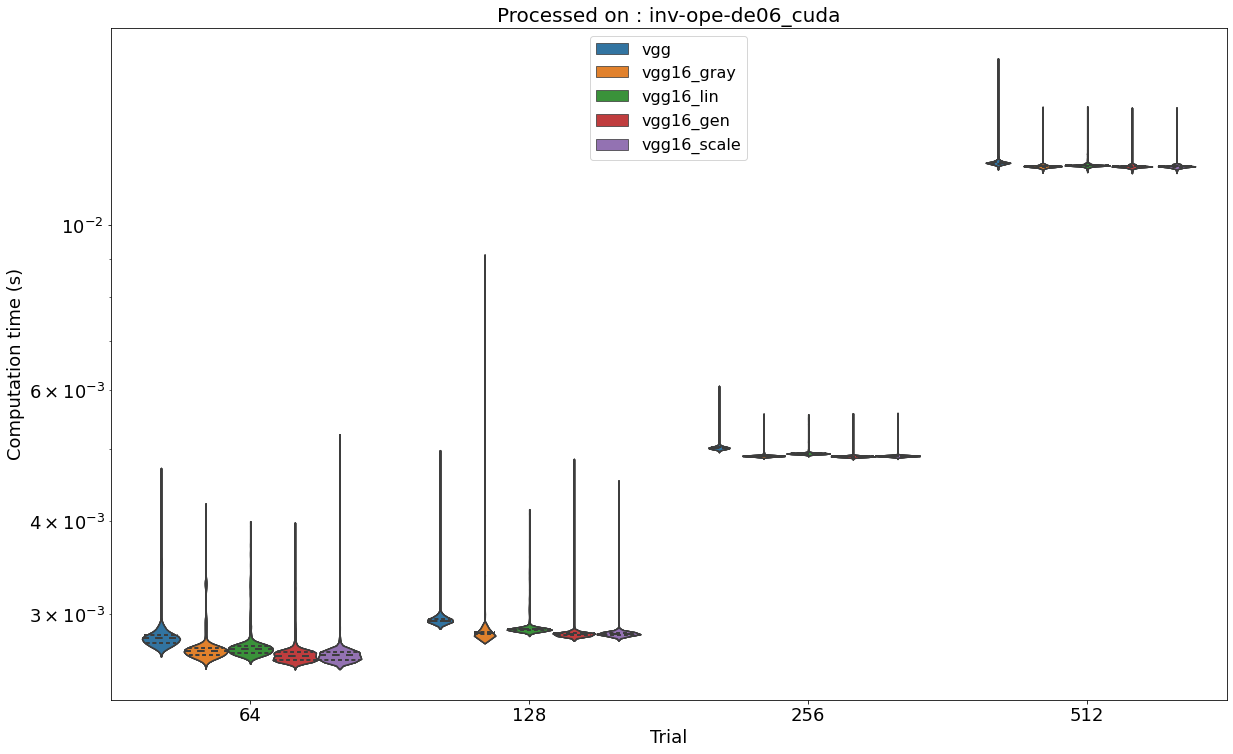

In [42]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for color, model_name in zip(colors, models_vgg.keys()):
    axs = sns.violinplot(x="image_size", y="time", data=df_downsample, inner="quartile", hue='model')
    axs.set_title('Processed on : ' + args.HOST + '_' + str(df_downsample['device_type'][0]), size = 20)
    axs.set_ylabel('Computation time (s)', size=18)
    axs.set_xlabel('Trial', size=18)
    axs.set_yscale('log')
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);

## Classification likelihood

Let's display the likelihood of each models on the same dataset for differents resolutions. Here accuracies are displayed as a violin plot to allow a better representation of the models.

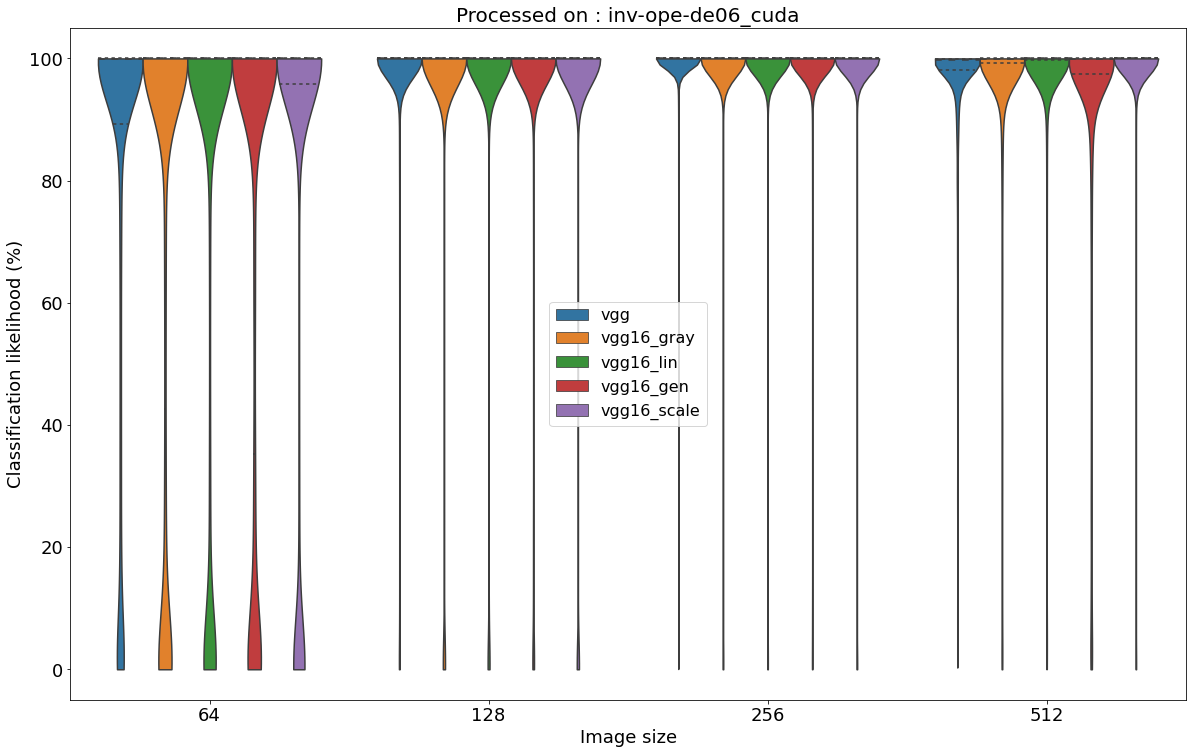

In [43]:
fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi))
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
axs = sns.violinplot(x="image_size", y="perf", data=df_downsample, inner="quartile", hue='model', cut = 0, scale = 'width')
axs.set_title('Processed on : ' + args.HOST + '_' + str(df_downsample['device_type'][0]), size=20)
axs.set_ylabel('Classification likelihood (%)', size=18)
axs.set_xlabel('Image size', size=18)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc ='center', fontsize=16);

## Image display

The 64 worsts classification likelihood, all models and sizes combined : 

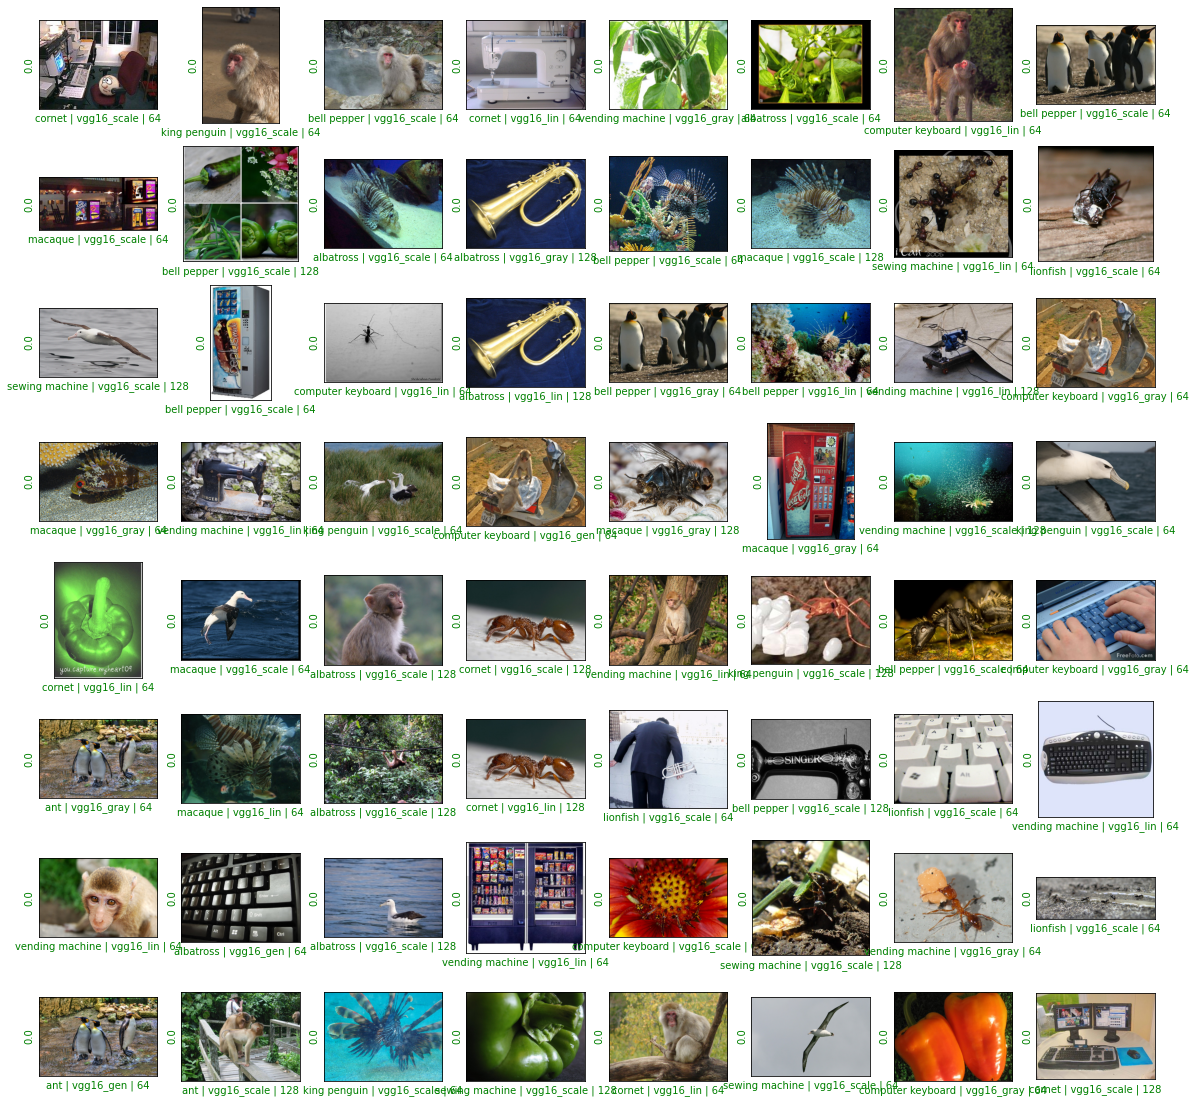

In [44]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width, fig_width))
for i, idx in enumerate(df_downsample["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df_downsample.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_downsample.loc[idx]['label'] + ' | ' + df_downsample.loc[idx]['model']+ ' | ' + str(df_downsample.loc[idx]['image_size']), color='g')
    perf_ = df_downsample.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')

## summary

Again, we extracted a specific mean for each models : 

Mean accuracy

In [45]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in image_sizes:
        df_ = df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]
        mean_acc = (df_["top_1"] == df_["label"]).mean()
        print(f'For size {image_size}, the mean accuracy = {mean_acc*100:.4f} %' )

----------------------
Benchmarking model vgg
----------------------
For size 64, the mean accuracy = 25.3705 %
For size 128, the mean accuracy = 65.6106 %
For size 256, the mean accuracy = 82.9075 %
For size 512, the mean accuracy = 74.9617 %
-----------------------------
Benchmarking model vgg16_gray
-----------------------------
For size 64, the mean accuracy = 74.7573 %
For size 128, the mean accuracy = 93.8171 %
For size 256, the mean accuracy = 97.5728 %
For size 512, the mean accuracy = 95.1456 %
----------------------------
Benchmarking model vgg16_lin
----------------------------
For size 64, the mean accuracy = 76.2136 %
For size 128, the mean accuracy = 94.4558 %
For size 256, the mean accuracy = 97.4962 %
For size 512, the mean accuracy = 96.1932 %
----------------------------
Benchmarking model vgg16_gen
----------------------------
For size 64, the mean accuracy = 74.3229 %
For size 128, the mean accuracy = 94.4558 %
For size 256, the mean accuracy = 97.7006 %
For size 51

Classification likelihood's mean

In [46]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["perf"])
        print(f'For size {image_size}, the mean clasification likelihood = {med_perf:.5f} %' )

----------------------
Benchmarking model vgg
----------------------
For size 64, the mean clasification likelihood = 81.86420 %
For size 128, the mean clasification likelihood = 96.45993 %
For size 256, the mean clasification likelihood = 98.76743 %
For size 512, the mean clasification likelihood = 96.15926 %
-----------------------------
Benchmarking model vgg16_gray
-----------------------------
For size 64, the mean clasification likelihood = 74.18123 %
For size 128, the mean clasification likelihood = 93.62557 %
For size 256, the mean clasification likelihood = 97.16454 %
For size 512, the mean clasification likelihood = 93.68116 %
----------------------------
Benchmarking model vgg16_lin
----------------------------
For size 64, the mean clasification likelihood = 76.00206 %
For size 128, the mean clasification likelihood = 94.31384 %
For size 256, the mean clasification likelihood = 97.34109 %
For size 512, the mean clasification likelihood = 95.01648 %
-------------------------

Computation time 's mean

In [47]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["time"])
        print(f'For size {image_size}, the mean computation time = {med_perf:.3f} s' )

----------------------
Benchmarking model vgg
----------------------
For size 64, the mean computation time = 0.003 s
For size 128, the mean computation time = 0.003 s
For size 256, the mean computation time = 0.005 s
For size 512, the mean computation time = 0.012 s
-----------------------------
Benchmarking model vgg16_gray
-----------------------------
For size 64, the mean computation time = 0.003 s
For size 128, the mean computation time = 0.003 s
For size 256, the mean computation time = 0.005 s
For size 512, the mean computation time = 0.012 s
----------------------------
Benchmarking model vgg16_lin
----------------------------
For size 64, the mean computation time = 0.003 s
For size 128, the mean computation time = 0.003 s
For size 256, the mean computation time = 0.005 s
For size 512, the mean computation time = 0.012 s
----------------------------
Benchmarking model vgg16_gen
----------------------------
For size 64, the mean computation time = 0.003 s
For size 128, the mea

Frame per second's mean

In [48]:
for model_name in models_vgg.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["fps"])
        print(f'For size {image_size}, the mean fps = {med_perf:.3f} Hz' )

----------------------
Benchmarking model vgg
----------------------
For size 64, the mean fps = 356.425 Hz
For size 128, the mean fps = 337.345 Hz
For size 256, the mean fps = 198.435 Hz
For size 512, the mean fps = 82.318 Hz
-----------------------------
Benchmarking model vgg16_gray
-----------------------------
For size 64, the mean fps = 370.229 Hz
For size 128, the mean fps = 351.306 Hz
For size 256, the mean fps = 203.903 Hz
For size 512, the mean fps = 83.290 Hz
----------------------------
Benchmarking model vgg16_lin
----------------------------
For size 64, the mean fps = 368.889 Hz
For size 128, the mean fps = 347.902 Hz
For size 256, the mean fps = 202.458 Hz
For size 512, the mean fps = 83.055 Hz
----------------------------
Benchmarking model vgg16_gen
----------------------------
For size 64, the mean fps = 377.435 Hz
For size 128, the mean fps = 353.665 Hz
For size 256, the mean fps = 204.227 Hz
For size 512, the mean fps = 83.316 Hz
------------------------------
Benc

# Experiment 3: Image processing and recognition on grayscale images :

Again, same likelihood indicators but now with a grayscale transformation.

In [49]:
scriptname = 'experiment_grayscale.py'

In [50]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_training_benchmark.model import *
filename = f'results/{datetag}_results_3_{args.HOST}.json'

def main():
    # Output's set up
    try:
        df_gray = pd.read_json(filename)
    except:
        df_gray = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device_type', 'top_1']) 
        i_trial = 0

        # image preprocessing setting a grayscale output
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size, p=1, batch_size=1)

        # Displays the input image of the model 
        for i_image, (data, label) in enumerate(dataloaders['test']):
            data, label = data.to(device), label.to(device)

            for model_name in models_vgg.keys():
                model = models_vgg[model_name]
                model = model.to(device)

                with torch.no_grad():
                    i_label_top = reverse_labels[image_datasets['test'].classes[label]]
                    tic = time.time()
                    out = model(data).squeeze(0)
                    if model_name == 'vgg' :
                        percentage = torch.nn.functional.softmax(out[args.i_labels], dim=0) * 100
                        _, indices = torch.sort(out, descending=True)
                        top_1 = labels[indices[0]]
                        perf_ = percentage[reverse_i_labels[i_label_top]].item()
                    else :
                        percentage = torch.nn.functional.softmax(out, dim=0) * 100
                        _, indices = torch.sort(out, descending=True)
                        top_1 = reverse_model_labels[indices[0]] 
                        perf_ = percentage[label].item()
                dt = time.time() - tic
                df_gray.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'device_type':device.type, 'top_1':str(top_1)}
                print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds, best confidence for : {top_1}')
                i_trial += 1
        df_gray.to_json(filename)


if __name__ == "__main__":
    main()    

Overwriting experiment_grayscale.py


In [51]:
%run -int {scriptname}


IPython CPU timings (estimated):
  User   :       0.00 s.
  System :       0.00 s.
Wall time:       0.00 s.


<Figure size 432x288 with 0 Axes>


Collecting all the results, displaying all the data in a table 

In [52]:
filename = f'results/{datetag}_results_3_{args.HOST}.json'
#filename = 'results/2021-04-20_results_3_INV-133-DE01.json'
df_gray = pd.read_json(filename)
df_gray

model       perf         fps      time            label  i_label  \
0              vgg  99.967125  162.117502  0.006168              ant      310   
1       vgg16_gray  98.923508  201.484556  0.004963              ant      310   
2        vgg16_lin  95.713387  203.045166  0.004925              ant      310   
3        vgg16_gen  99.818573  205.764521  0.004860              ant      310   
4      vgg16_scale  99.999046  206.707604  0.004838              ant      310   
...            ...        ...         ...       ...              ...      ...   
19565          vgg  99.778580  233.887470  0.004276  vending machine      886   
19566   vgg16_gray  99.977074  240.388812  0.004160  vending machine      886   
19567    vgg16_lin  98.389748  239.114304  0.004182  vending machine      886   
19568    vgg16_gen  22.449202  240.899661  0.004151  vending machine      886   
19569  vgg16_scale  99.949577  239.838975  0.004169  vending machine      886   

       i_image                                  filename device_type  \
0            0             data/test/albatross/01771.jpg        cuda   
1            0             data/test/albatross/01771.jpg        cuda   
2            0             data/test/albatross/01771.jpg        cuda   
3            0             data/test/albatross/01771.jpg        cuda   
4            0             data/test/albatross/01771.jpg        cuda   
...        ...                                       ...         ...   
19565     3913  data/test/vending machine/yonaturals.jpg        cuda   
19566     3913  data/test/vending machine/yonaturals.jpg        cuda   
19567     3913  data/test/vending machine/yonaturals.jpg        cuda   
19568     3913  data/test/vending machine/yonaturals.jpg        cuda   
19569     3913  data/test/vending machine/yonaturals.jpg        cuda   

                   top_1  
0                    ant  
1                    ant  
2                    ant  
3                    ant  
4                    ant  
...                  ...  
19565    vending machine  
19566    vending machine  
19567    vending machine  
19568  computer keyboard  
19569    vending machine  

[19570 rows x 10 columns]

## Accuracy, Precision, Recall

<ipython-input-53-d539ab816ca5>:25: RuntimeWarning: invalid value encountered in long_scalars
  pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))


Text(0.5, 0, 'Models')

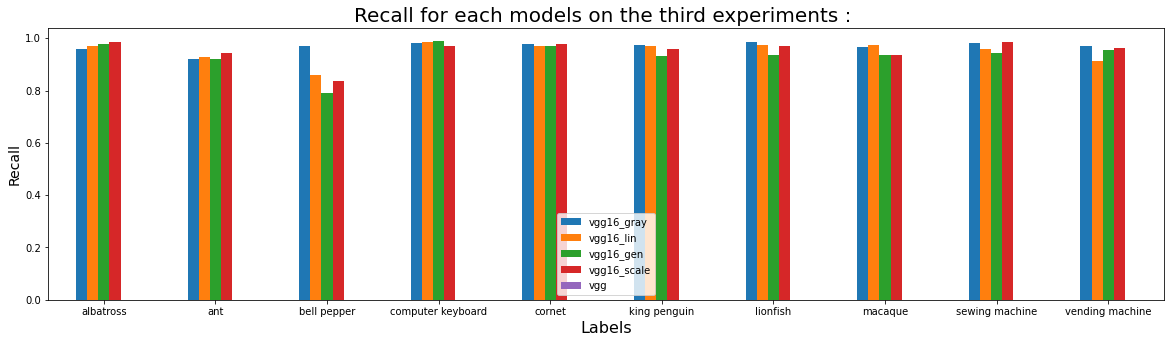

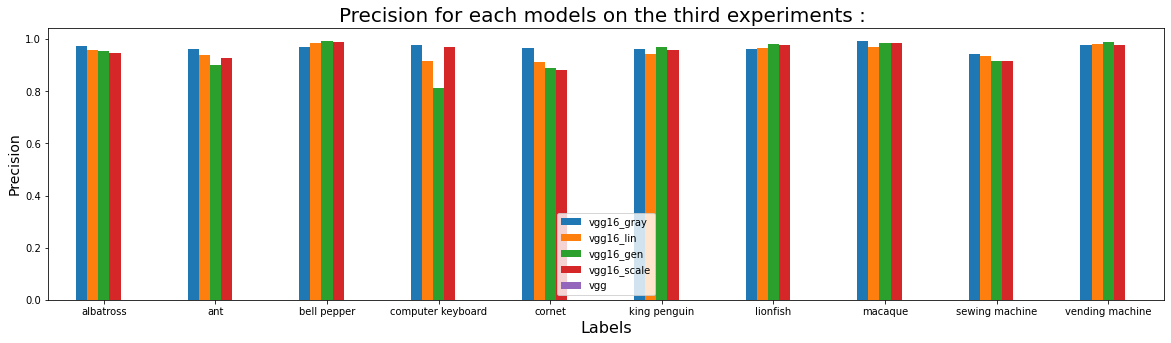

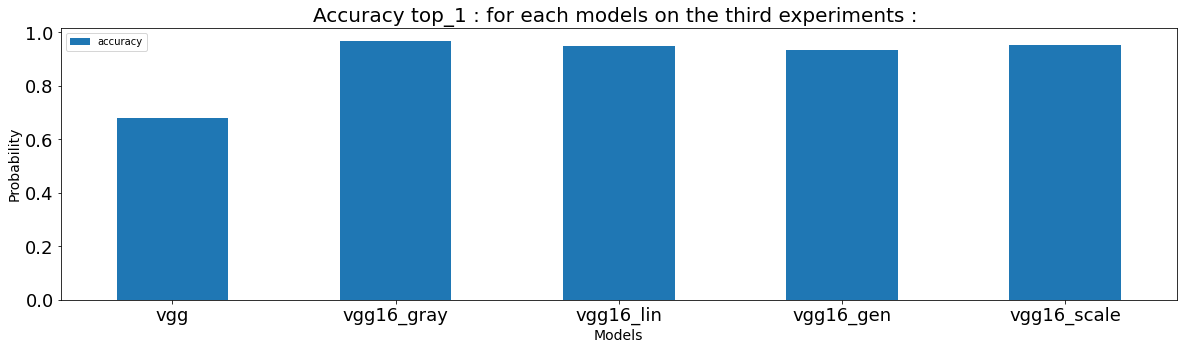

In [53]:
results = {} 
results['acc'] = []
results['precision'] = {}
results['recall'] = {}

for model_name in models_vgg.keys():
    #pprint('Model : ' + model_name)
    model_pred = df_gray[df_gray['model']==model_name]["top_1"].values.tolist()
    ground_truth = df_gray[df_gray['model']==model_name]["label"].values.tolist()
    acc = sklearn.metrics.accuracy_score(ground_truth, model_pred)
    results['acc'].append(acc)
    #print(f'Accuracy top_1 : {acc:.3f}')
    pres = sklearn.metrics.multilabel_confusion_matrix(ground_truth, model_pred)
    results['precision'][model_name] = []
    #pprint('Precision :')
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[-1][0]))
        results['precision'][model_name].append(pres_)
        #print(f'{pres_:.3f} for the label {label}')
    results['recall'][model_name] = []
    #pprint('Recall :')
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))
        results['recall'][model_name].append(pres_)
        #print(f'{pres_:.3f} for the label {label}')

for mode in ['recall', 'precision']:
    df_acc = pd.DataFrame({'vgg16_gray': results[mode]['vgg16_gray'],
                        'vgg16_lin': results[mode]['vgg16_lin'],
                         'vgg16_gen': results[mode]['vgg16_gen'],
                          'vgg16_scale': results[mode]['vgg16_scale'],
                           'vgg': results[mode]['vgg'],
                      }, index=reverse_model_labels)
    ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
    ax.set_title(mode.capitalize()+' for each models on the third experiments : ', size=20)
    ax.set_ylabel(mode.capitalize(), size=14)
    ax.set_xlabel('Labels', size=16)
df_acc = pd.DataFrame({'accuracy': results['acc']},
                  index = models_vgg.keys())
ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 18)
ax.set_title('Accuracy top_1 : for each models on the third experiments : ', size=20)
ax.set_ylabel('Probability', size=14)
ax.set_xlabel('Models', size=14)

## Computation time

A display of the differents computation time of each models on the same dataset for a single resolution :

In [54]:
df_gray['time'].min(), df_gray['time'].max(), df_gray['time'].quantile(.005), len(df_gray[df_gray['model']==model_name]['time'])

(0.004062891, 0.0061683655, 0.0040807724, 3914)

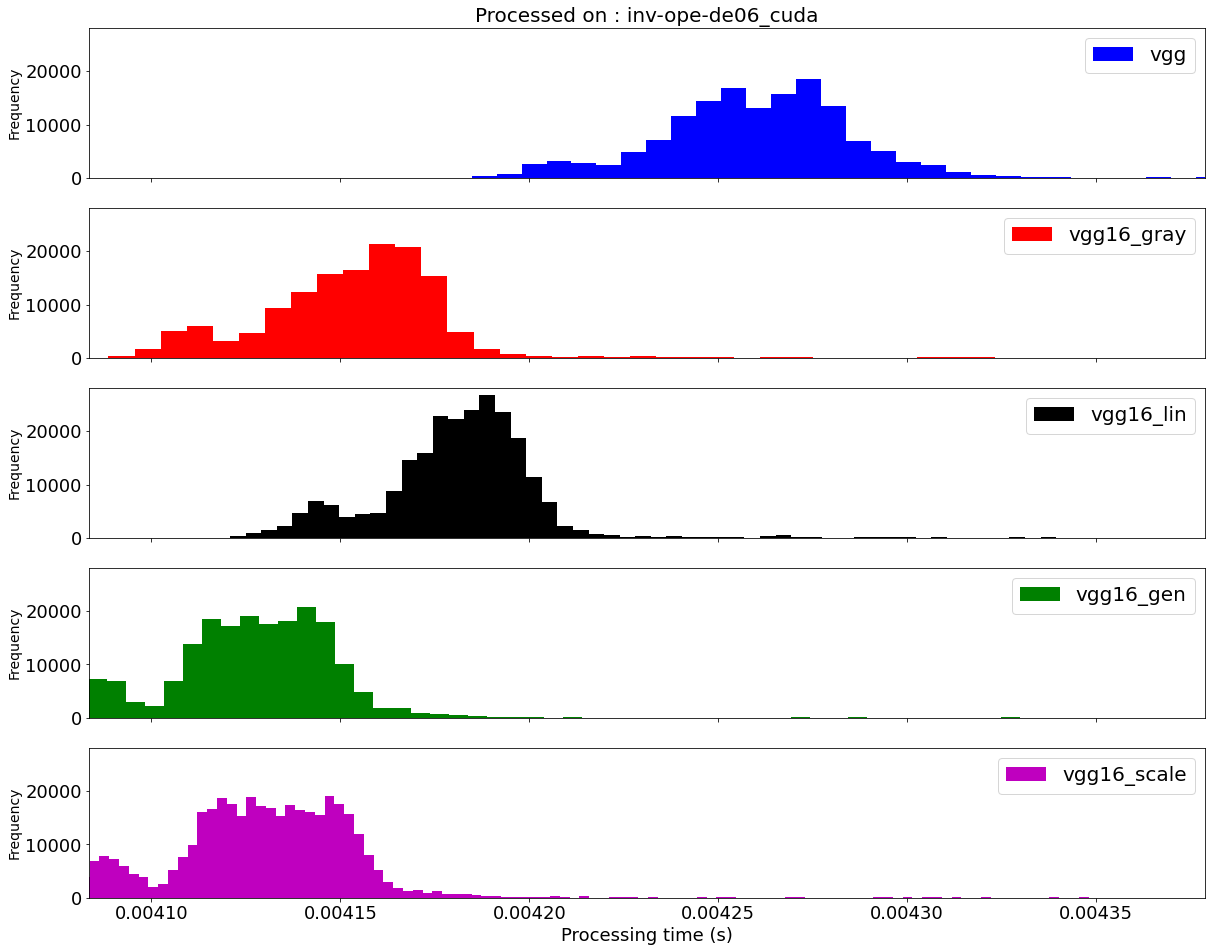

In [55]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2), sharex=True, sharey=True)
for ax, color, model_name in zip(axs, colors, models_vgg.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df_gray[df_gray['model']==model_name]['time'].plot.hist(bins=300, lw=1, label=model_name,ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlim(df_gray['time'].quantile(.01), df_gray['time'].quantile(.99))
    ax.legend(loc='upper right', fontsize=20)
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## Classification likelihood

A display of the classification likelihood of each models on the same dataset for a single resolution :

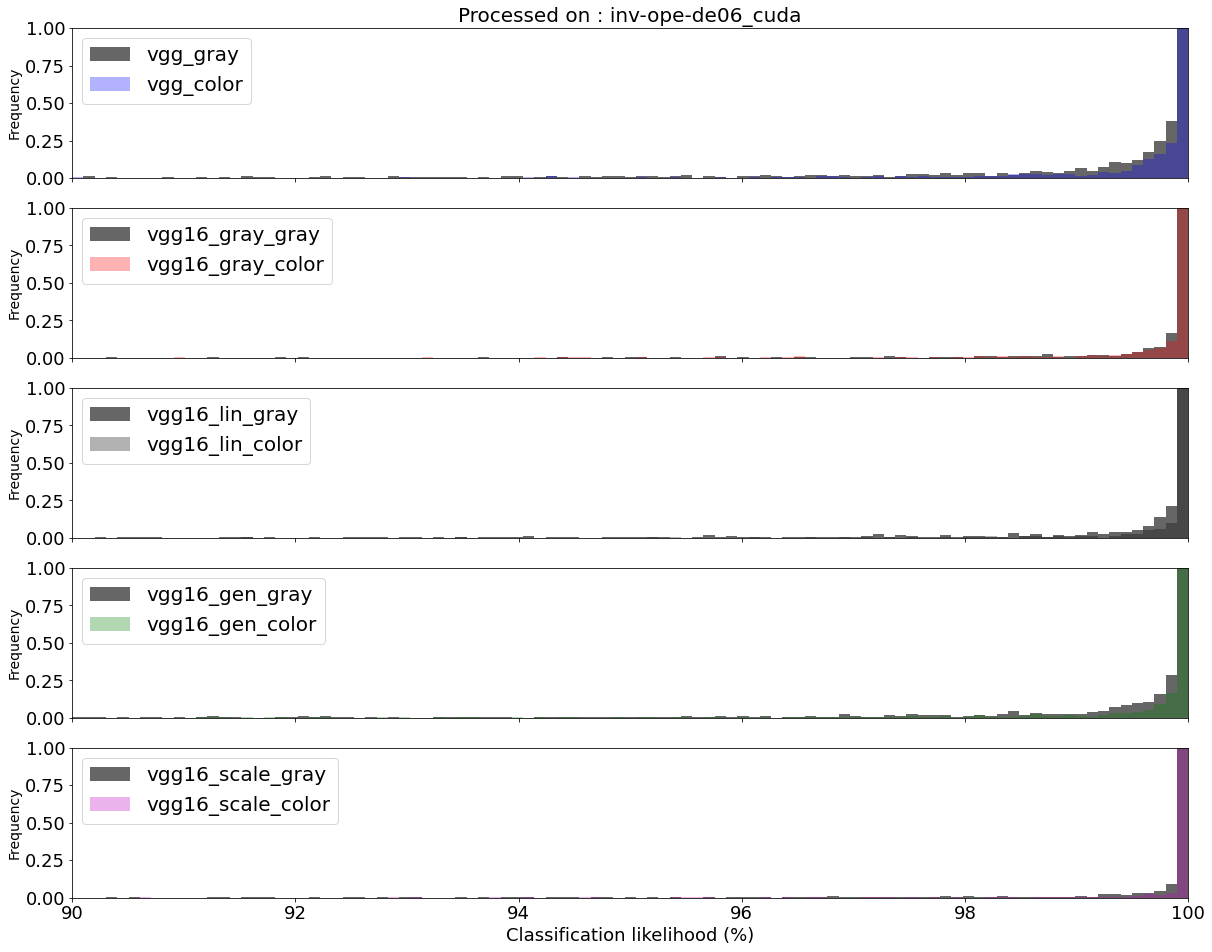

In [56]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2), sharex=True, sharey=True)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models_vgg.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df_gray[df_gray['model']==model_name]['perf'].plot.hist(bins=np.linspace(90, 100, 100), lw=0, alpha=0.6, label=model_name + '_gray', ax=ax, color='k', density=True)
    df[df['model']==model_name]['perf'].plot.hist(bins=np.linspace(90, 100, 100), lw=0, alpha=0.3, label=model_name + '_color', ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize=20)
    ax.set_xlim(90, 100)
    ax.set_ylim(0, 1)
    # ax.tick_params(axis='x', labelsize=14)
    # ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification likelihood (%)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

## Image display

The 64 worsts classification likelihood, all model combined : 

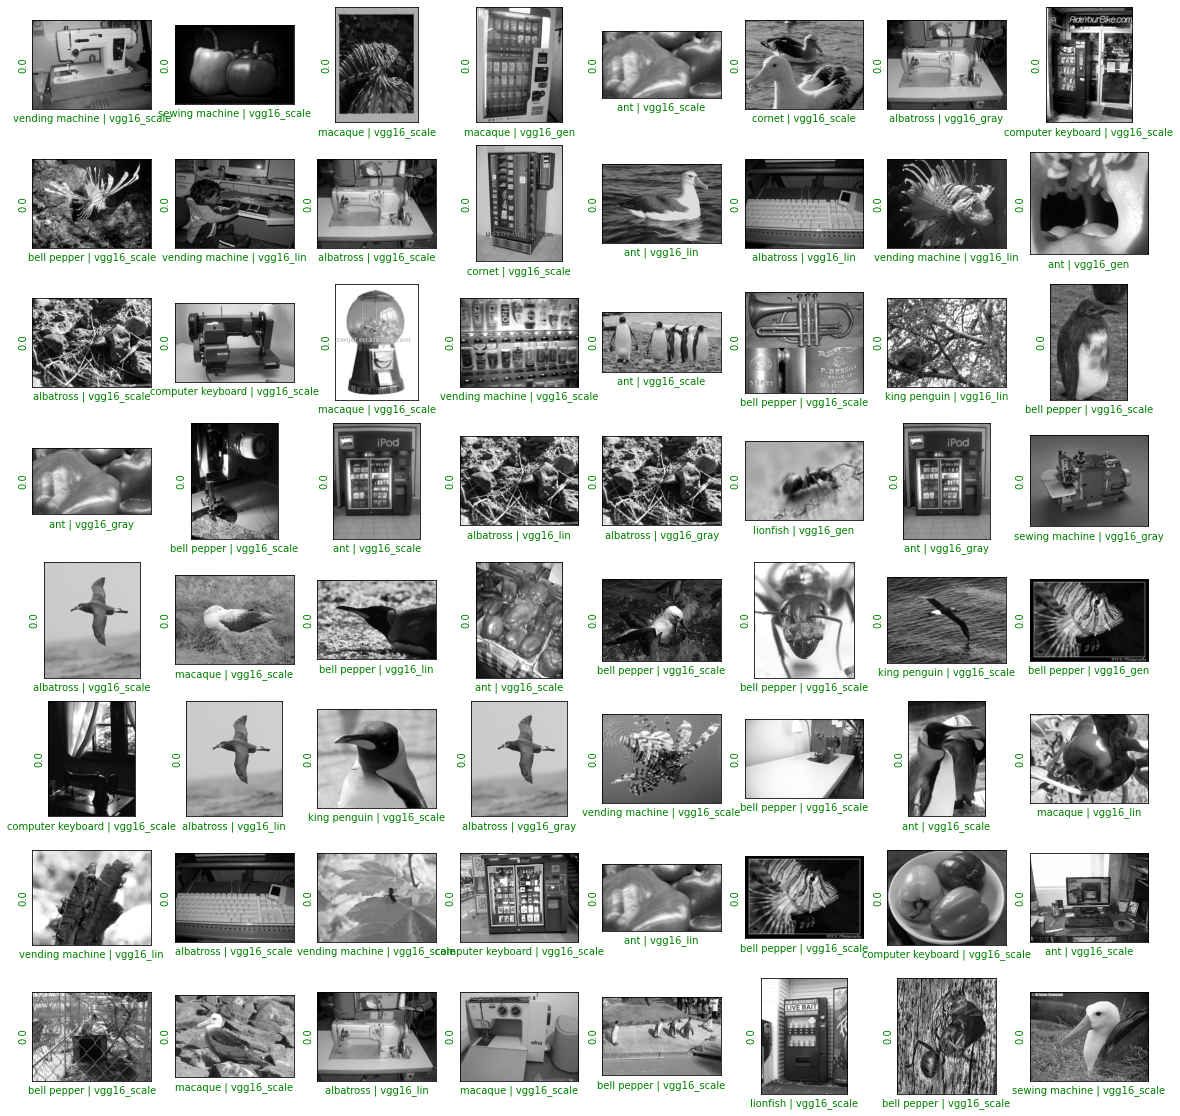

In [57]:
N_image_i = 8
N_image_j = 8

fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width, fig_width))
for i, idx in enumerate(df_gray["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df_gray.loc[idx]['i_image']][0], pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_gray.loc[idx]['label'] + ' | ' + df_gray.loc[idx]['model'], color='g')
    perf_ = df_gray.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')

## summary


### Computation time compared with experiment 1

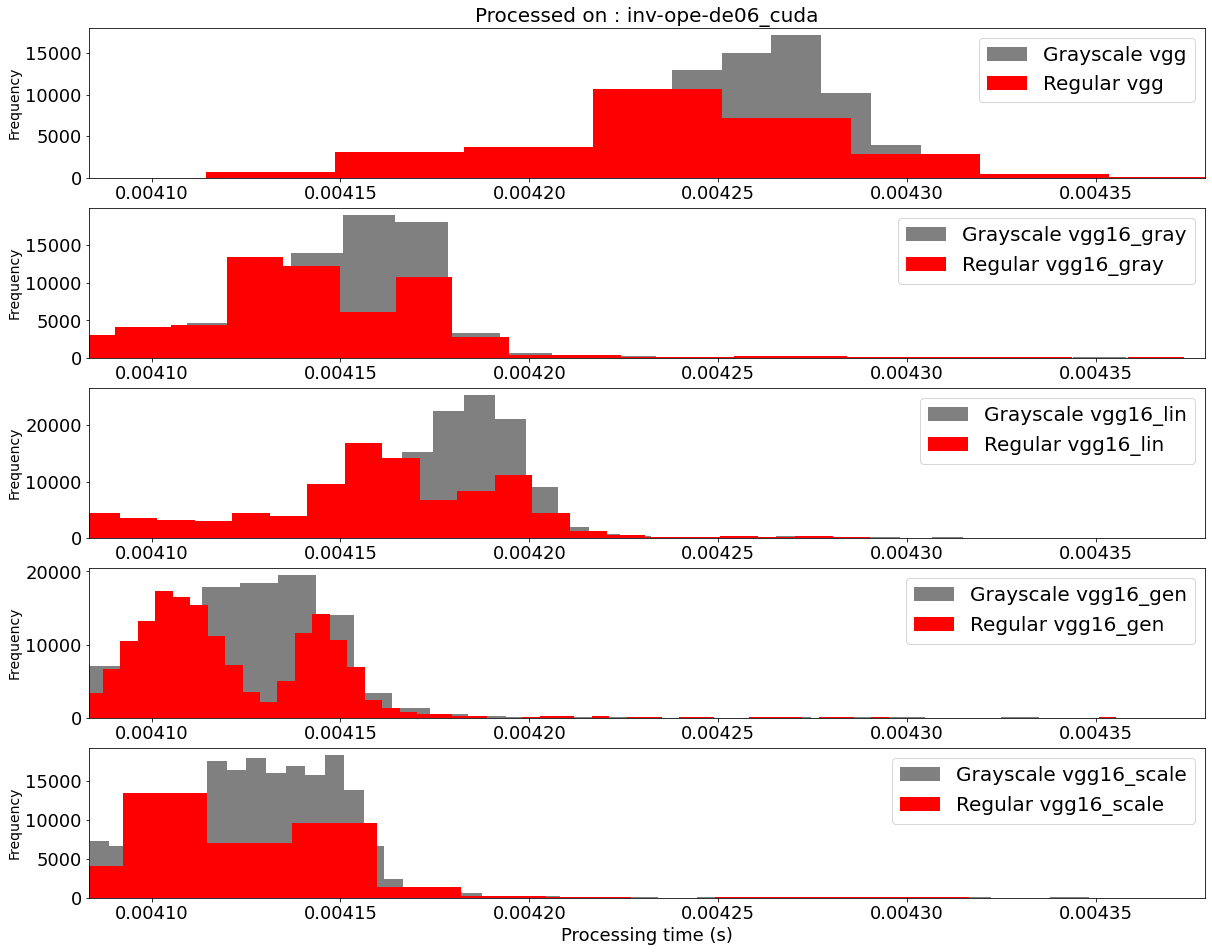

In [58]:
fig, axs = plt.subplots(len(models_vgg.keys()), 1, figsize=(fig_width, fig_width*phi//2))
for color, df_, label, legend in zip(['gray', 'red'], [df_gray, df], ['black', 'color'], ['Grayscale', 'Regular']):
    for ax, model_name in zip(axs, models_vgg.keys()):
        ax.set_ylabel('Frequency', fontsize=14) 
        df_[df_['model']==model_name]['time'].plot.hist(bins=150, lw=1, label=str(legend+ ' ' + model_name), ax=ax, color=color, density=True)
        ax.legend(loc='upper right', fontsize=20)
        ax.set_xlim(df_gray['time'].quantile(.01), df_gray['time'].quantile(.99))
axs[-1].set_xlabel('Processing time (s)', size=18)
axs[0].set_title('Processed on : ' + args.HOST + '_' + str(df['device_type'][0]), size = 20);

### Classification likelihood compared with experiment 1

Let's analyze the classification likelihood of each models on the same dataset for color versus grayscale images. Here likelihood's are displayed as a violin plot to allow a better representation of the models.

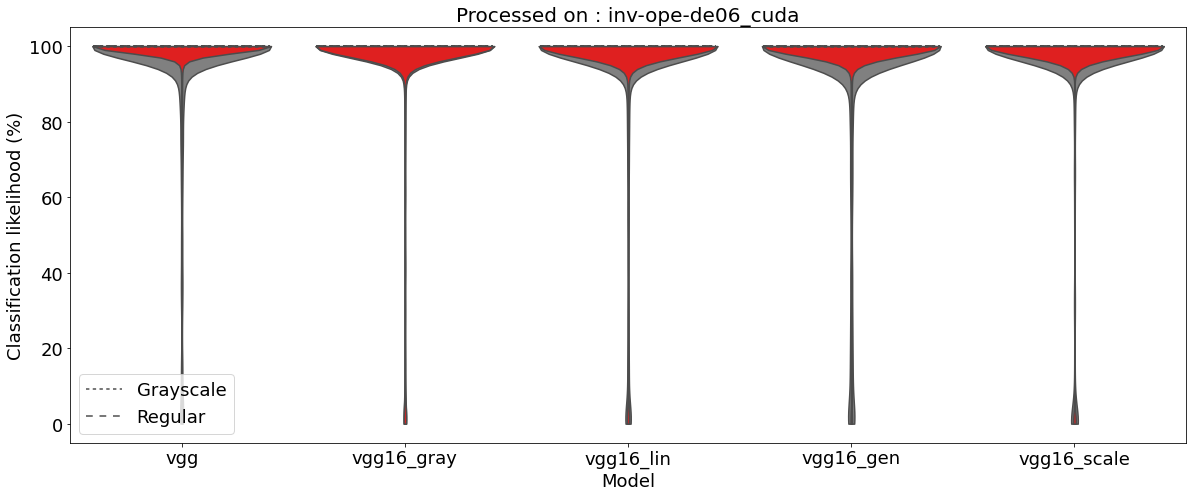

In [59]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi**2))
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
for color, df_, label in zip(['gray', 'red'], [df_gray, df], ['black', 'color']):
    axs = sns.violinplot(x="model", y="perf", data=df_, inner="quartile", cut=0, color=color, alpha=.5, scale = 'width')
    axs.set_title('Processed on : ' + args.HOST + '_' + str(df_['device_type'][0]), size=20)
    axs.set_ylabel('Classification likelihood (%)', size=18)
    axs.legend(['Grayscale', 'Regular'], fontsize=18)
    axs.set_xlabel('Model', size=18)

### Mean compared with experiment 1

Mean accuracy

In [60]:
for model_name in models_vgg.keys():
    mean_acc_orig = (df[df['model']==model_name]["top_1"] == df[df['model']==model_name]["label"]).mean()
    mean_acc = (df_gray[df_gray['model']==model_name]["top_1"] == df_gray[df_gray['model']==model_name]["label"]).mean()
    print(f'For the {model_name} model, the mean clasification likelihood = {mean_acc*100:.5f} % (color = {mean_acc_orig*100:.5f} % )' )

For the vgg model, the mean clasification likelihood = 67.93562 % (color = 82.80531 % )
For the vgg16_gray model, the mean clasification likelihood = 96.90853 % (color = 97.36842 % )
For the vgg16_lin model, the mean clasification likelihood = 95.01788 % (color = 97.54727 % )
For the vgg16_gen model, the mean clasification likelihood = 93.43383 % (color = 98.05825 % )
For the vgg16_scale model, the mean clasification likelihood = 95.19673 % (color = 97.80276 % )


Classification likelihood's mean

In [61]:
for model_name in models_vgg.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["perf"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["perf"])
    print(f'For the {model_name} model, the mean clasification likelihood = {med_perf:.5f} % (color = {med_perf_orig:.5f} % )' )
    print(stats.ttest_1samp(df_gray[df_gray['model']==model_name]["perf"], np.mean(df[df['model']==model_name]["perf"])))

For the vgg model, the mean clasification likelihood = 94.79861 % (color = 98.66654 % )
Ttest_1sampResult(statistic=-13.737044220200124, pvalue=5.653464095515097e-42)
For the vgg16_gray model, the mean clasification likelihood = 96.58831 % (color = 97.12189 % )
Ttest_1sampResult(statistic=-2.1048482453807105, pvalue=0.035368120313559764)
For the vgg16_lin model, the mean clasification likelihood = 94.35782 % (color = 97.30765 % )
Ttest_1sampResult(statistic=-9.141503384773962, pvalue=9.663356310964741e-20)
For the vgg16_gen model, the mean clasification likelihood = 92.52054 % (color = 97.52875 % )
Ttest_1sampResult(statistic=-13.812751489674154, pvalue=2.0801804641462304e-42)
For the vgg16_scale model, the mean clasification likelihood = 94.83600 % (color = 97.80277 % )
Ttest_1sampResult(statistic=-9.0744435869684, pvalue=1.7698544986279715e-19)


Computation time 's mean

In [62]:
for model_name in models_vgg.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["time"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["time"])
    print(f'For the {model_name} model, the mean computation time = {med_perf:.4f} s (color = {med_perf_orig:.4f} s )' )

For the vgg model, the mean computation time = 0.0043 s (color = 0.0042 s )
For the vgg16_gray model, the mean computation time = 0.0042 s (color = 0.0041 s )
For the vgg16_lin model, the mean computation time = 0.0042 s (color = 0.0042 s )
For the vgg16_gen model, the mean computation time = 0.0041 s (color = 0.0041 s )
For the vgg16_scale model, the mean computation time = 0.0041 s (color = 0.0041 s )


Frame per second's mean

In [63]:
for model_name in models_vgg.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["fps"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["fps"])
    print(f'For the {model_name} model, the mean fps = {med_perf:.3f} Hz (color = {med_perf_orig:.3f} Hz )' )

For the vgg model, the mean fps = 234.339 Hz (color = 235.560 Hz )
For the vgg16_gray model, the mean fps = 240.377 Hz (color = 241.620 Hz )
For the vgg16_lin model, the mean fps = 239.020 Hz (color = 240.422 Hz )
For the vgg16_gen model, the mean fps = 242.108 Hz (color = 243.647 Hz )
For the vgg16_scale model, the mean fps = 241.999 Hz (color = 243.383 Hz )
